In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import csv
import re
import sys
import codecs
from ast import literal_eval
from sklearn.model_selection import train_test_split
from fasttext_preprocessing.fasttext_preprocessing import *
import spacy
import pyphen
from collections import Counter

In this part we build the neural network allowing us to do some words predictions on the lyrics and transform them from one genre to another. First we will visualize the amount of lyrics that we have for each genre:

In [2]:
lyrics_df = pd.read_csv('../kaggleDataset/lyrics_final_clean.csv')
MAIN_GENRES = {'pop', 'rock', 'metal', 'country', 'jazz', 'hip hop'}
# For now just work on pop and rock genres
print(len(lyrics_df))
lyrics_df.head(10)

317015


,artist,genre,lyrics,song,year
0,beyonce-knowles,pop,oh baby how you doing\nyou know i m gonna cut ...,ego-remix,2009.0
1,beyonce-knowles,pop,playin everything so easy\nit s like you seem...,then-tell-me,2009.0
2,beyonce-knowles,pop,if you search\nfor tenderness\nit isn t hard t...,honesty,2009.0
3,beyonce-knowles,pop,oh oh oh i oh oh oh i\n\nif i wrote a book abo...,you-are-my-rock,2009.0
4,beyonce-knowles,pop,party the people the people the party it s pop...,black-culture,2009.0
5,beyonce-knowles,pop,i heard\nchurch bells ringing\ni heard\na choi...,all-i-could-do-was-cry,2009.0
6,beyonce-knowles,pop,this is just another day that i would spend\nw...,once-in-a-lifetime,2009.0
7,beyonce-knowles,pop,waiting waiting waiting waiting\nwaiting waiti...,waiting,2009.0
8,beyonce-knowles,pop,\ni read all of the magazines\nwhile waiting a...,slow-love,2009.0
9,beyonce-knowles,pop,nnnow honey\nyou better sit down and look arou...,why-don-t-you-love-me,2009.0


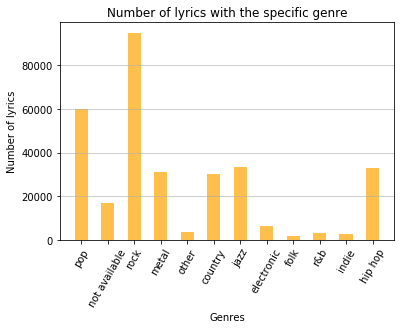

In [5]:
n, bins, patches = plt.hist(x = list(lyrics_df["genre"]), bins=np.arange(0,len(set(lyrics_df["genre"])) + 1), color='orange', align = 'left', alpha=0.7, rwidth=0.5)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Genres')
plt.ylabel('Number of lyrics')
plt.title('Number of lyrics with the specific genre')
plt.xticks(rotation=60)
plt.show()

We will only focus on genres with sufficient number of lyrics: rock, pop, metal, jazz, country, hip hop. For each of these genres we have more than 30'000 lyrics in our dataset

## Input pre-processing

Import the dictionnaries of word embeddings computed previously with fasttext:

In [6]:
# Load embeddings
file_vec = 'fasttext_preprocessing/model_lyrics_skipgram.vec'
file_bin = 'fasttext_preprocessing/model_lyrics_skipgram.bin' # Not useful and file too big for Github
fasttext_exe = 'fasttext_preprocessing/fasttext'

def load_embeddings(file_name):
    """
    Load the embeddings from the .vec file given as input
    """
    with codecs.open(file_name, 'r', 'utf-8') as f_in:
        lines = f_in.readlines()
        lines = lines[1:]
        vocabulary, wv = zip(*[line.strip().split(' ', 1) for line in lines])
    wv = np.loadtxt(wv)
    return wv, vocabulary

# This method is typically called for words with no embeddings in the dictionary
def get_embedding_for_missing_word(w):
    """
    Given a word as input, computes it's fasttext vector using the file_bin file
    """
    data = ! echo $w | $fasttext_exe print-word-vectors $file_bin
    emb = np.zeros(100)
    for i, x in enumerate(data[0].split( )[1:]):
        try:
            emb[i] = float(x)
        except ValueError:
            print(data[0])
    return emb

word_embeddings, vocabulary = load_embeddings(file_vec)

In [7]:
# Create dictionaries
voc_embeds_dict = {}
embeds_voc_dict = {}

for voc, embed in zip(vocabulary, word_embeddings):
    voc_embeds_dict[voc] = tuple(embed)
    embeds_voc_dict[tuple(embed)] = voc
    
print(len(voc_embeds_dict))

85899


Search for all the words in the lyrics that are not in the embeddings.

In [424]:
# THIS CELL TAKES LONG TIME TO RUN: NO NEED TO RUN WITH missing_words.csv file
def find_missing_words(lyrics, vocab):
    """
    Given lyrics of songs, find the words in it that are not in the vocabulary (word embeddings)
    """
    sentences = str(lyrics).replace('\n', ' ')
    list_words = sentences.split(' ')
    missing_words = set(list_words).difference(vocab)
    return missing_words


vocab = set(voc_embeds_dict.keys())
missing_vocab = set()

for i, row in lyrics_df.iterrows():
    if i % 1000 == 999:
        print(float(i)/ len(lyrics_df))
    lyrics = row['lyrics']
    missing_words = find_missing_words(lyrics, vocab)
    
    missing_vocab = missing_vocab.union(missing_words)
    vocab = vocab.union(missing_words)

0.0031512704446161853
0.0063056953141018566
0.009460120183587528
0.012614545053073198
0.01576896992255887
0.01892339479204454
0.02207781966153021
0.02523224453101588
0.028386669400501552
0.031541094269987226
0.03469551913947289
0.037849944008958566
0.04100436887844424
0.04415879374792991
0.04731321861741558
0.05046764348690125
0.05362206835638692
0.056776493225872596
0.05993091809535826
0.06308534296484393
0.06623976783432961
0.06939419270381528
0.07254861757330094
0.07570304244278662
0.07885746731227229
0.08201189218175796
0.08516631705124363
0.0883207419207293
0.09147516679021497
0.09462959165970064
0.09778401652918632
0.10093844139867199
0.10409286626815765
0.10724729113764334
0.110401716007129
0.11355614087661467
0.11671056574610034
0.11986499061558602
0.12301941548507168
0.12617384035455737
0.12932826522404303
0.1324826900935287
0.13563711496301437
0.13879153983250003
0.1419459647019857
0.1451003895714714
0.14825481444095706
0.15140923931044273
0.1545636641799284
0.157718089049414

In [425]:
# Remove duplicates
missing_vocab_lst = list(set(missing_vocab_lst))
print(len(missing_vocab_lst))
print(missing_vocab_lst[:50])

229149
['', 'keopeulling', 'faithmy', 'abraim', 'lutenant', 'drup', 'pinehill', 'dubar', 'proovalizing', 'mour', 'amortization', 'macmahon', 'wohohohoh', 'dribs', '146', 'vechouski', 'stevies', 'speciments', 'dauphine', 'machangajingeol', 'eastends', 'misquete', 'leatherfeathered', 'ayyet', 'melodytrouble', 'lamarque', 'fashionkilla', 'heemed', 'ghuana', 'yanamean', 'clannad', 'strategized', 'blaoww', 'chicagoo', 'arthgolano', 'brk', 'trickier', 'macgregors', 'mimimimind', 'giddedygot', 'asseth', 'willliehaeyyy', 'polako', 'mahuckin', 'telltales', 'dahomey', 'honeypie', 'virany', 'twentymillion', 'berlington']


In [8]:
missing_words_file = 'fasttext_preprocessing/missing_words.csv'
# Save missing words
"""with open(missing_words_file, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in missing_vocab_lst:
        writer.writerow([val])"""
        
# Read missing words
with open(missing_words_file, 'r') as f:
    reader = csv.reader(f)
    missing_vocab_lst = [ls_word[0] for ls_word in list(reader)]
print("{} distinct missing words".format(len(missing_vocab_lst)))

229149 distinct missing words


The idea was to fetch the embeddings of all these missing words using the get_embedding_for_missing_word function. However, this took way too long to compute for all the missing words.

Most of the missing words are actual words with a bad ortograph: lots of them contain a same letter repeating lots of time (e.g. Wwwwwworld instead of world). Thus we use regex to map these words to their actual correct representation:

In [9]:
vocab = set(voc_embeds_dict.keys())
bad_good_word_dict = {}
for i, w in enumerate(missing_vocab_lst):
    correct_w = re.sub(r'(.)\1{2,}', r'\1', w)
    if correct_w in vocab:
        bad_good_word_dict[w] = correct_w
print("Number of correct mapped words: {}".format(len(bad_good_word_dict)))

Number of correct mapped words: 5568


Now let's transform the lyrics as follows. For each word:

    - If the word is in the voc_embeds_dict dictionary, keep the word (he has an embedding)
    - Else if the word is in the bad_good_word_dict, fetch the corresponding good word (missing word with a matching)
    - Else remove the word from the lyrics (we don't have his emnedding and it's too long to compute it for each word)

Transform lyrics by keeping only the words that have fasttext embeddings

In [10]:
def lyrics_to_list_words(lyrics, vocab):
    """
    Given lyrics of songs, keep only the words with the embeddings
    """
    sentences = str(lyrics).replace('\n', ' ') # Don't consider end of words
    list_words = sentences.split(' ')
    list_words_cleaned = []
    incorrect_count = 0
    
    for w in list_words:
        if w in voc_embeds_dict.keys():
            list_words_cleaned.append(w)
        elif w in bad_good_word_dict.keys():
            # Get matching word
            correct_w = bad_good_word_dict[w]
            list_words_cleaned.append(correct_w)
        else: 
            # Word with no embedding, don't consider it
            incorrect_count += 1 
    return list_words_cleaned, incorrect_count

In [11]:
def get_list_words_from_df(df, vocab):
    """
    Given a dataframe, apply the lyrics_to_list_words on each lyrics of the dataframe
    """
    lyrics_cleaned = []
    total_incorrect = 0

    for i, row in df.iterrows():    
        lyrics = row['lyrics']
        words_cleaned, c = lyrics_to_list_words(str(lyrics), vocab)
        total_incorrect += c
        lyrics_cleaned.append(words_cleaned)
    print("Average of incorrect words per song: {}".format(float(total_incorrect) / len(df)))
    return lyrics_cleaned

def list_lyrics_genre(entire_df, entire_vocab, genre):
    """
    Get the list of lyrics with "non-missing" words (list of words) for a given genre
    """
    df_genre = entire_df[entire_df['genre'] == genre]
    print("Number lyrics for genre {} : {}".format(genre, len(df_genre)))
    list_lyrs_genre = get_list_words_from_df(df_genre, entire_vocab)
    return list_lyrs_genre

In [12]:
vocab = set(voc_embeds_dict.keys())
list_lyrics = get_list_words_from_df(lyrics_df, vocab)

Average of incorrect words per song: 8.113108212545148


In [14]:
list_lyrs_pop = list_lyrics_genre(lyrics_df, vocab, 'pop')
list_lyrs_rock = list_lyrics_genre(lyrics_df, vocab, 'rock')
list_lyrs_metal = list_lyrics_genre(lyrics_df, vocab, 'metal')
list_lyrs_jazz = list_lyrics_genre(lyrics_df, vocab, 'jazz')
list_lyrs_hiphop = list_lyrics_genre(lyrics_df, vocab, 'hip hop')
list_lyrs_country = list_lyrics_genre(lyrics_df, vocab, 'country')

Number lyrics for genre pop : 59850
Average of incorrect words per song: 9.592147034252298
Number lyrics for genre rock : 94938
Average of incorrect words per song: 3.3855147569993047
Number lyrics for genre metal : 31320
Average of incorrect words per song: 6.085983397190294
Number lyrics for genre jazz : 33536
Average of incorrect words per song: 9.372286498091603
Number lyrics for genre hip hop : 33024
Average of incorrect words per song: 23.560804263565892
Number lyrics for genre country : 30247
Average of incorrect words per song: 7.217244685423347


Depending on the genre we have more or less words with missing embedding but this number isn't huge except for hip hop lyrics (23.5 missing words per song in average). We figured out that it is ok to remove these words from the lyrics !

Check lengths of lyrics repartitions and we keep only the lyrics with more than 30 words, otherwise lyrics might be outliers.

In [15]:
def get_lyrics_above(list_lyrics, min_nbr_words = 30):
    lengths_lyrics = [len(l) for l in list_lyrics]
    print("Words per lyrics: Min: {}, Max: {}, Avg: {}".format(min(lengths_lyrics), max(lengths_lyrics), np.mean(lengths_lyrics)))

    # Keep lyrics with more than certain number of words
    list_lyrics_nomin = [l for l in list_lyrics if len(l) > min_nbr_words]
    lengths_lyrics = [len(l) for l in list_lyrics_nomin]
    print("Ratio lyrics kept: {}".format(len(list_lyrics_nomin) / len(list_lyrics)))
    return list_lyrics_nomin, lengths_lyrics

In [16]:
list_lyrs_pop, lengths_pop = get_lyrics_above(list_lyrs_pop)
list_lyrs_rock, lengths_rock = get_lyrics_above(list_lyrs_rock)
list_lyrs_metal, lengths_metal = get_lyrics_above(list_lyrs_metal)
list_lyrs_jazz, lengths_jazz = get_lyrics_above(list_lyrs_jazz)
list_lyrs_hiphop, lengths_hiphop = get_lyrics_above(list_lyrs_hiphop)
list_lyrs_country, lengths_country = get_lyrics_above(list_lyrs_country)

Words per lyrics: Min: 0, Max: 3365, Avg: 247.924544695071
Ratio lyrics kept: 0.9945196324143692
Words per lyrics: Min: 0, Max: 6300, Avg: 202.37651941266932
Ratio lyrics kept: 0.9892982788767406
Words per lyrics: Min: 0, Max: 2377, Avg: 188.33288633461046
Ratio lyrics kept: 0.9791507024265645
Words per lyrics: Min: 0, Max: 2380, Avg: 183.74349952290078
Ratio lyrics kept: 0.9926645992366412
Words per lyrics: Min: 1, Max: 8179, Avg: 503.35425750968994
Ratio lyrics kept: 0.9904009205426356
Words per lyrics: Min: 0, Max: 2736, Avg: 199.3980890666843
Ratio lyrics kept: 0.9972889873375872


### Exclusive words for each genre

For this part we decided, for each genre, to compute the words appearing exclusively in this genre and not in the other ones. We also ensured that these found words are real words by comparing them with a dictionary of the english language (list words from nltk library).

The idea behind this: 
Because the vocabulary of words is huge, we would like to sample some words for each genre such that these words will be the possible words that our neural network will predict. In order to predict good words for a specific genre, we thought about considering these "exclusive" words as possible outputs for our neural network for the specific genre (and add other words). However, we remarked that these exclusive words might not appear a lot of time and this would reduce the whole size of the training set for our neural net. Moreover, we remarked that these unique words are "weird" words because they don't appear at all in all the other lyrics of the other genres. We decided not to use these words and found a better and smarter alternative that will be explained after.    

In [17]:
def unique_words(list_lyrs):
    """
    Given list of lyrics (list of words), return the set of all words
    """
    all_words = []
    for l in list_lyrs:
        for w in l:
            all_words.append(w)
    unique_words = set(all_words)
    print("Number of unique words: {}".format(len(unique_words)))
    return unique_words 

In [18]:
# Distinct words
words_pop = unique_words(list_lyrs_pop)
words_rock = unique_words(list_lyrs_rock)
words_metal = unique_words(list_lyrs_metal)
words_jazz = unique_words(list_lyrs_jazz)
words_hiphop = unique_words(list_lyrs_hiphop)
words_country = unique_words(list_lyrs_country)

# Common words in all genres
common_words = words_metal.intersection(words_rock).intersection(words_pop).intersection(words_jazz).intersection(words_hiphop).intersection(words_country)
print(len(common_words))

Number of unique words: 57083
Number of unique words: 59368
Number of unique words: 44487
Number of unique words: 41731
Number of unique words: 61796
Number of unique words: 35441
20373


In [19]:
from nltk.corpus import words
# If needed to download package word, uncomment 2 nex lines
#import nltk
#nltk.download('words')

exclusive_metal = words_metal.difference(words_rock.union(words_pop).union(words_jazz).union(words_hiphop).union(words_country))
exclusive_pop = words_pop.difference(words_rock.union(words_metal).union(words_jazz).union(words_hiphop).union(words_country))
exclusive_rock = words_rock.difference(words_metal.union(words_pop).union(words_jazz).union(words_hiphop).union(words_country))
exclusive_jazz = words_jazz.difference(words_rock.union(words_pop).union(words_metal).union(words_hiphop).union(words_country))
exclusive_hiphop = words_hiphop.difference(words_rock.union(words_pop).union(words_jazz).union(words_metal).union(words_country))
exclusive_country = words_country.difference(words_rock.union(words_pop).union(words_jazz).union(words_hiphop).union(words_metal))

# Keep only real existing words given by the nltk library
exclusive_metal = set(words.words()).intersection(exclusive_metal)
exclusive_pop = set(words.words()).intersection(exclusive_pop)
exclusive_rock = set(words.words()).intersection(exclusive_rock)
exclusive_jazz = set(words.words()).intersection(exclusive_jazz)
exclusive_hiphop = set(words.words()).intersection(exclusive_hiphop)
exclusive_country = set(words.words()).intersection(exclusive_country)

### Part Of Speech (POS) for each genre:

For each genre we go through the lyrics of this genre and compute the POS distribution of the genre, the count of apparitions of each words, the POS of each words. For the POS of each word, sometimes a word can have multiple POS: (e.g. increase can either be a NOUN or VERB), so we consider the final POS that appears the most for each word. 

In [20]:
# Spacy library to compute the Parts Of Speeches (POS) in a sentence
en_nlp = spacy.load('en')

Possible POS:

ADJ: adjective ADP: adposition ADV: adverb AUX: auxiliary verb CONJ: coordinating conjunction DET: determiner INTJ: interjection NOUN: noun NUM: numeral PART: particle PRON: pronoun PROPN: proper noun PUNCT: punctuation SCONJ: subordinating conjunction SYM: symbol VERB: verb X: other

In [21]:
def generate_pos_for_lyrics(lyrs):
    """
    Compute the Part Of Speech (POS) of each word for given lyrics and return the list of POS and counter for these lyrics
    """
    doc = en_nlp(lyrs)
    word_pos_dict = {}
    list_pos = []
    
    for i in range(len(doc)):
        type_ = doc[i].pos_
        if type_ != 'SPACE' and type_ != 'PART' and type_ != 'X': # We don't want to keep these POS
            list_pos.append(type_)
            if str(doc[i]) not in word_pos_dict.keys():
                word_pos_dict[str(doc[i])] = {type_: 1}
            elif type_ not in word_pos_dict[str(doc[i])].keys():
                word_pos_dict[str(doc[i])][type_] = 1
            else:
                word_pos_dict[str(doc[i])][type_] += 1
    # list_pos: the list of POS appearing in the lyrics
    # Counter(list_pos): counter of each distinct POS apparition in the lyrics
    # word_pos_dict: dictionary of format: {word1: {pos1: count, pos2: count, ....}, word2: {pos1: count, pos2: count, ....}, ...}
    return list_pos, Counter(list_pos), word_pos_dict

def update_word_pos_dict(w_pos_dict1, w_pos_dict2):
    """
    Function that updates the w_pos_dictionary by adding the key or / and values from w_pos_dict2
    """
    # parameters -> {word1: {pos1: count, pos2: count, ....}, word2: {pos1: count, pos2: count, ....}, ...}
    
    res = w_pos_dict1.copy()
    for w, pos_dict2 in w_pos_dict2.items():
        if w not in res.keys():
            # Add the pos, counts dictionary for w in the main dictionary
            res[w] = pos_dict2
        else:
            # Combine the 2 POS, counts dictionaries for word w
            pos_dict1 = res[w].copy()
            for pos, count in pos_dict2.items():
                if pos in pos_dict1.keys():
                    # Increment the count
                    pos_dict1[pos] += count
                else:
                    # Add the new POS and count
                    pos_dict1[pos] = count
            res[w] = pos_dict1
    return res

def get_pos_count_from_df(list_lyrics):
    """
    Given the whole list of lyrics, compute the number of POS in all lyrics(pos_counter), 
    the apparition of each word in all the lyrics (word_counter), and the corresponding POS for each of this word (final_word_pos_dict)
    """
    print("Number of lyrics: {}".format(len(list_lyrics)))
    pos_counter = Counter()
    word_counter = Counter()
    total_word_pos_dict = {}
    
    for i, list_words in enumerate(list_lyrics):
        if i % 1000 == 999:
            print(float(i) / len(list_lyrics))
        
        # We don't consider the first word as we are not able to predict it from the previous words
        _, counter, word_pos_dict = generate_pos_for_lyrics(' '.join(list_words[1:])) 
        pos_counter += counter
        word_counter += Counter(list_words)
        total_word_pos_dict = update_word_pos_dict(total_word_pos_dict, word_pos_dict)
    
    final_word_pos_dict = {}
    for w, pos_dict in total_word_pos_dict.items():
        max_pos = max(pos_dict, key = pos_dict.get)
        final_word_pos_dict[w] = max_pos
        
    return pos_counter, word_counter, final_word_pos_dict

In [1210]:
"""Takes some times to compute, we saved all the data in files"""
#pop_pos_counter, pop_word_counter, pop_word_pos_dict = get_pos_count_from_df(list_lyrs_pop)
#met_pos_counter, met_word_counter, met_word_pos_dict = get_pos_count_from_df(list_lyrs_metal)
#jazz_pos_counter, jazz_word_counter, jazz_word_pos_dict = get_pos_count_from_df(list_lyrs_jazz)
#country_pos_counter, country_word_counter, country_word_pos_dict = get_pos_count_from_df(list_lyrs_country)
#hip_pos_counter, hip_word_counter, hip_word_pos_dict = get_pos_count_from_df(list_lyrs_hiphop)
#rock_pos_counter, rock_word_counter, rock_word_pos_dict = get_pos_count_from_df(list_lyrs_rock)

Number of lyrics: 93922
0.01063648559442942
0.021283618321585998
0.03193075104874257
0.04257788377589915
0.05322501650305573
0.06387214923021231
0.07451928195736889
0.08516641468452546
0.09581354741168203
0.10646068013883861
0.11710781286599518
0.12775494559315176
0.13840207832030835
0.1490492110474649
0.1596963437746215
0.17034347650177808
0.18099060922893465
0.19163774195609123
0.2022848746832478
0.21293200741040438
0.22357914013756094
0.23422627286471753
0.24487340559187412
0.2555205383190307
0.26616767104618727
0.27681480377334383
0.2874619365005004
0.298109069227657
0.30875620195481357
0.31940333468197013
0.33005046740912675
0.3406976001362833
0.35134473286343987
0.36199186559059643
0.37263899831775305
0.3832861310449096
0.39393326377206617
0.4045803964992228
0.41522752922637934
0.4258746619535359
0.43652179468069247
0.4471689274078491
0.45781606013500564
0.4684631928621622
0.4791103255893188
0.4897574583164754
0.500404591043632
0.5110517237707886
0.5216988564979451
0.532345989225

In [22]:
# Cell to save and / or load the 3 dictionaries of a specific genre

def dict_to_csv(path, dict_):
    with open(path, "w") as f:
        writer = csv.writer(f)
        for key, value in dict_.items():
            writer.writerow([key, value])
        
def csv_to_dict(path):
    with open(path, "r") as f:
        reader = csv.reader(f)
        dict_ = dict(reader)
    return dict_

def get_files_from_genre(genre):
    pos_file = 'NN_models/' + genre + '/' + genre + '_pos_counter.csv'
    word_file = 'NN_models/' + genre + '/' + genre + '_word_counter.csv'
    word_pos_file = 'NN_models/' + genre + '/' + genre + '_word_pos.csv'
    
    # Read csv files to create dictionaries
    pos_counter_dict = csv_to_dict(pos_file)
    word_counter_dict = csv_to_dict(word_file)
    word_pos_dict = csv_to_dict(word_pos_file)
    
    # We are not interested in all POS: PUNCT or SYM not important
    pos_to_keep = {'INTJ','NOUN','ADV','PRON','VERB','ADP','DET','CCONJ','ADJ','NUM','PROPN'} 
    pos_counter_dict = {k:v for k,v in pos_counter_dict.items() if k in pos_to_keep}
    word_pos_dict = {k:v for k,v in word_pos_dict.items() if v in pos_to_keep}
    
    return pos_counter_dict, word_counter_dict, word_pos_dict

# Save dictionaries to csv files:
"""genre = 'rock'
pos_file = 'NN_models/' + genre + '/' + genre + '_pos_counter.csv'
word_file = 'NN_models/' + genre + '/' + genre + '_word_counter.csv'
word_pos_file = 'NN_models/' + genre + '/' + genre + '_word_pos.csv'
    
dict_to_csv(pos_file, rock_pos_counter)
dict_to_csv(word_file, rock_word_counter)
dict_to_csv(word_pos_file, rock_word_pos_dict)"""

# Read csv files to create dictionaries
pop_pos_counter, pop_word_counter, pop_word_pos_dict = get_files_from_genre('pop')
rock_pos_counter, rock_word_counter, rock_word_pos_dict = get_files_from_genre('rock')
metal_pos_counter, metal_word_counter, metal_word_pos_dict = get_files_from_genre('metal')
jazz_pos_counter, jazz_word_counter, jazz_word_pos_dict = get_files_from_genre('jazz')
hip_pos_counter, hip_word_counter, hip_word_pos_dict = get_files_from_genre('hiphop')
country_pos_counter, country_word_counter, country_word_pos_dict = get_files_from_genre('country')

In [23]:
def get_distrib_pos(pos_counter_dict):
    """
    Computes the distribution of POS given the dictionary POS -> count for a given genre
    """
    total = np.sum([int(elem) for elem in pos_counter_dict.values()])
    distrib_dict = {}
    
    for key, value in pos_counter_dict.items():
        distrib_dict[key] = float(value) / total
    return distrib_dict

pop_pos_distrib = get_distrib_pos(pop_pos_counter)
rock_pos_distrib = get_distrib_pos(rock_pos_counter)
metal_pos_distrib = get_distrib_pos(metal_pos_counter)
country_pos_distrib = get_distrib_pos(country_pos_counter)
jazz_pos_distrib = get_distrib_pos(jazz_pos_counter)
hip_pos_distrib = get_distrib_pos(hip_pos_counter)

print("Pop Distribution:")
print(pop_pos_distrib)

Pop Distribution:
{'NOUN': 0.19276193171973033, 'ADV': 0.08198539710305533, 'PRON': 0.15895478063838622, 'VERB': 0.2643048408229971, 'ADP': 0.08763619154411462, 'DET': 0.07565409071450818, 'CCONJ': 0.029392494146212735, 'ADJ': 0.08588414598757374, 'INTJ': 0.017080696046527663, 'NUM': 0.005104399007677646, 'PROPN': 0.0012410322692164562}


From the previous dictionaries, we create a new one with POS type as key and lists of tuples (word with this POS, count of the words) as values. The list is sorted in decreasing order of count. 

#### From now on, we do all the computations uniquely on the Pop genre to avoid code redundancy, but it works the exact same way with other genres and we did it with all other genres to compute the specific neural network of each genre.  

In [25]:
pos_list = list(pop_pos_counter.keys())

def get_pos_words_dict(pos_list, word_count_dict, word_pos_dict):

    pos_words_dict = {pos:[] for pos in pos_list}
    
    # Add tuples (words, count) to the dictionary
    for w, count in word_count_dict.items():
        if w in word_pos_dict.keys(): # Don't consider words with no POS (typically the ones from the list no_pos_words)
            pos = word_pos_dict[w]
            pos_words_dict[pos].append((w, int(count)))
        
    # Sort each value lists on the count (x[1]) parameter from most to least appearing word 
    for pos in pos_words_dict.keys():
        pos_words_dict[pos].sort(key = lambda x: x[1], reverse = True)
        
    return pos_words_dict

pop_pos_words_dict = get_pos_words_dict(pos_list, pop_word_counter, pop_word_pos_dict)


### Most common words for each genre :

We previously saw that using exclusive words wasn't such a great idea. In this section we found a better alternative that consists in using the count of words of one genre (i.e. pop genre) and compute the difference of counts between each word of this genre and the same word in the other genres:

$$\Delta Pop_{w1} = count Pop_{w1} - (count Rock_{w1} + count Metal_{w1} + count Jazz_{w1} + count Country_{w1} + count Hip hop_{w1})$$

We then sort the list by decreasing difference such that the first words are the most common to the pop genre.

In [26]:
def get_diff_words_counts(genre_word_count_dict, others_word_count_dicts, genre, threshold = 100):
    """
    From the first dictionary, compute the difference between count of words in this dict with count of all other dicts.
    """
    # Keep only words appearing at least a certain amount of times
    diff_dict = {k:int(v) for k, v in genre_word_count_dict.items() if int(v) > threshold}
    for w in diff_dict.keys():
        for other_dict in others_word_count_dicts:
            if w in other_dict.keys():
                count = int(other_dict[w])
                diff_dict[w] -= count
    
    # return a sorted list
    diff_list = [(k,v) for k,v in diff_dict.items()]
    diff_list.sort(key = lambda x: x[1], reverse = True)
    
    # THIS PART IS HARDCODED BY OBSERVING MOST APPEARING WORDS FOR EACH GENRE
    if genre == 'pop':
        # Most appearing words in this genre are french or spanish -> take words below 0
        diff_list =  [(k,v) for k,v in diff_list if v < 0]
    if genre == 'rock':
        # Most appearing words are nonsense -> take words below 80
        diff_list =  [(k,v) for (k,v) in diff_list if v < 80]
        
    # metal, jazz, country -> all good; hip hop -> seems good but dirty :O
    return diff_list


threshold = 200
other_dicts = np.array([rock_word_counter, pop_word_counter, metal_word_counter, jazz_word_counter, country_word_counter, hip_word_counter])

rock_diff_list = get_diff_words_counts(rock_word_counter, other_dicts[1:], 'rock', threshold)
pop_diff_list = get_diff_words_counts(pop_word_counter, other_dicts[[0,2,3,4,5]], 'pop', threshold)
metal_diff_list = get_diff_words_counts(metal_word_counter, other_dicts[[0,1,3,4,5]], 'metal', threshold)
jazz_diff_list = get_diff_words_counts(jazz_word_counter, other_dicts[[0,1,2,4,5]], 'jazz', threshold)
country_diff_list = get_diff_words_counts(country_word_counter, other_dicts[[0,1,2,3,5]], 'country', threshold)
hip_diff_list = get_diff_words_counts(hip_word_counter, other_dicts[:5], 'hiphop', threshold)

In [27]:
nbr_words = 10
print("Rock exclusive {} most appearing words : {}\n".format(nbr_words, rock_diff_list[:nbr_words]))
print("Pop exclusive {} most appearing words : {}\n".format(nbr_words, pop_diff_list[:nbr_words]))
print("Metal exclusive {} most appearing words : {}\n".format(nbr_words, metal_diff_list[:nbr_words]))
print("Jazz exclusive {} most appearing words : {}\n".format(nbr_words, jazz_diff_list[:nbr_words]))
print("Country exclusive {} most appearing words : {}\n".format(nbr_words, country_diff_list[:nbr_words]))
print("Hip Hop exclusive {} most appearing words : {}\n".format(nbr_words, hip_diff_list[:nbr_words]))

Rock exclusive 10 most appearing words : [('bored', 63), ('jaded', 43), ('brilliant', 15), ('headlines', 3), ('chemicals', -6), ('rocker', -19), ('saves', -26), ('isolation', -28), ('crashing', -30), ('failing', -31)]

Pop exclusive 10 most appearing words : [('ee', -6), ('ohohoh', -14), ('mickey', -21), ('como', -24), ('du', -27), ('vie', -29), ('ne', -35), ('bom', -39), ('es', -49), ('por', -58)]

Metal exclusive 10 most appearing words : [('eternal', 326), ('damnation', 248), ('ov', 217), ('morbid', 204), ('infernal', 204), ('legions', 179), ('corpses', 171), ('torment', 168), ('stench', 163), ('realm', 160)]

Jazz exclusive 10 most appearing words : [('liza', 118), ('hep', 98), ('accustomed', 77), ('darn', 0), ('doggone', -65), ('marvelous', -88), ('tricky', -91), ('lordy', -98), ('wail', -134), ('willow', -201)]

Country exclusive 10 most appearing words : [('honky', 284), ('tonk', 213), ('mem', 212), ('mhm', 161), ('cowboy', 139), ('hank', 134), ('ries', 102), ('nashville', 88), 

### Sample words for a specific genre:

The sampling is done based on:
    - n: the approximate number of words we want to sample
    - exclusive_words: the list of most common words appearing only in the wanted genre
    - pos_words_dict: the dictionary of POS -> list of words, count (sorted) qualified as this POS
    - pos_distrib: the dictionary of POS -> float between 0 and 1 being the distribution of POS we want to approximate with the sampling
    - word_pos_dict: the dictionary of word -> POS of this word
    - word_counter: the dictionary of word -> count of this word in vocabulary of genre
    - threshold: the minimum number of count we accept to consider a word for the sampling

In [28]:
def get_sample(n, exclusive_words, pos_words_dict, pos_distrib, word_pos_dict, word_counter, threshold = 5):
    """
    Given a target n (wanted number of words), get the sample of words to keep for output of the neural net 
    """
    # Keep exclusive words above threshold
    # List already sorted by count
    excl_words_tokeep = [w for w, count in exclusive_words if w in word_pos_dict.keys()]#w in exclusive_words if w in word_counter.keys() and int(word_counter[w]) >= threshold]
    
    # Check distribution of the pos of these exclusive words
    pos_words_sample_dict = {k:[] for k in pos_distrib.keys()}
    pos_actual_distrib = {k:0.0 for k in pos_distrib.keys()}
    
    # We just add a ratio of "exclusive words" in order to also add most common words in all genres to generate correct lyrics in the end
    ratio_exclusive_words = 0.5
    
    for w in excl_words_tokeep:
        pos = word_pos_dict[w]
        distrib = pos_actual_distrib[pos] 
        if distrib < pos_distrib[pos] * ratio_exclusive_words:
            # if we did not reach the max distribution: add it to the dictionary
            pos_actual_distrib[pos] += 1.0/n
            pos_words_sample_dict[pos].append(w)
    
    # Add regular words to complete the wanted distribution from pos_distribution
    most_common_idx = 20
    for pos, max_distrib in pos_distrib.items():
        actual_distrib = pos_actual_distrib[pos]
        lst_words = pos_words_dict[pos]
        exclusive_words = pos_words_sample_dict[pos]
        
        # Get most common words with given POS and add them such that they do not exceed wanted distribution 
        most_common_words = [(w,c) for w, c in lst_words[:most_common_idx] if c >= threshold and w not in exclusive_words]
        
        if len(lst_words) > most_common_idx:
            # Sample from lst_words (keep words not added before and with a count above threshold)
            lst_words = [(w,c) for w, c in lst_words[most_common_idx:] if c >= threshold and w not in exclusive_words]
            
            # Sample randomly some of the words in lst_words
            max_idx = min(int(n / 3), len(lst_words))
            to_sample = min(int(np.floor(max_distrib * n)), max_idx)
            #print(pos, to_sample, len(lst_words))
            if to_sample > 0:
                # Sample words with counts above threshold and not in lst_words
                most_common_words += random.sample(lst_words[:max_idx], to_sample)
            
        for w, count in most_common_words:
            # Add them if distribution not exceeded
            
            if actual_distrib < max_distrib + 0.001:
                actual_distrib += 1.0/n
                pos_words_sample_dict[pos].append(w)
        
        pos_actual_distrib[pos] = actual_distrib 
    return pos_words_sample_dict, pos_actual_distrib  

In [29]:
pop_sample_dict, pop_sample_distrib = get_sample(1500, pop_diff_list, pop_pos_words_dict, pop_pos_distrib, pop_word_pos_dict, pop_word_counter, threshold)

nbr_out = sum([len(lst) for k, lst in pop_sample_dict.items()])

print("Number of words sampled: {}\n".format(nbr_out))
print("Lyrics POS distribution: {}\n".format(pop_pos_distrib))
print("Sample POS distribution: {}\n".format(pop_sample_distrib))

print("Nouns from pop sampled: ")
print(pop_sample_dict['NOUN'])

Number of words sampled: 1122

Lyrics POS distribution: {'NOUN': 0.19276193171973033, 'ADV': 0.08198539710305533, 'PRON': 0.15895478063838622, 'VERB': 0.2643048408229971, 'ADP': 0.08763619154411462, 'DET': 0.07565409071450818, 'CCONJ': 0.029392494146212735, 'ADJ': 0.08588414598757374, 'INTJ': 0.017080696046527663, 'NUM': 0.005104399007677646, 'PROPN': 0.0012410322692164562}

Sample POS distribution: {'NOUN': 0.19400000000000076, 'ADV': 0.08333333333333333, 'PRON': 0.01733333333333333, 'VERB': 0.2653333333333345, 'ADP': 0.05666666666666676, 'DET': 0.010666666666666666, 'CCONJ': 0.005333333333333334, 'ADJ': 0.0873333333333333, 'INTJ': 0.01866666666666666, 'NUM': 0.006666666666666668, 'PROPN': 0.0026666666666666666}

Nouns from pop sampled: 
['ohohoh', 'mickey', 'como', 'vie', 'ne', 'bom', 'por', 'weezy', 'runway', 'tokyo', 'nana', 'que', 'butterflies', 'halo', 'mistletoe', 'si', 'ohoh', 'mmmm', 'emergency', 'betcha', 'deh', 'chi', 'wonderland', 'bonnie', 'tenderness', 'dame', 'presents',

We sampled pop words by trying to respect the same distribution of POS as in the actual pop lyrics. However, for some POS, the distribution is reduced (e.g. pronouns, deteminants). This is because there is not so many words such as pronouns or determinants that exist and by including all of these pronouns / determinants, the distribution can't increase.
This is not an issue as our neural network will learn to predict a word with the correct wanted POS that we want.

It could have been interesting to analyze the tradeoffs between the number of words that we want to sample and the threshold that we set. The higher the number of words to sample is, the higher the number of words to predict as outputs of the neural network, thus the accuracy of correct predictions might decrease. The higher the threshold, the more we get rid of outlier words but we might remove some specific words of the genre that we are interested in predict with our neural net.

We thought that 1500 was a good number of words to sample and 200 was a good threshold even though we can see that there are some outliers (i.e. spanish or french words) 

### Words Tokenization:

We map each distinct word to an integer and convert the list of lyrics to the corresponding list of indices 

In [30]:
# Keras imports
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Input, Embedding, LSTM, Dense, concatenate, BatchNormalization, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from scipy import sparse
import pickle
import random

Using TensorFlow backend.


In [ ]:
# Tokenize on all possible words with embeddings
tokenizer = Tokenizer(num_words = len(vocab))
tokenizer.fit_on_texts(list_lyrics)

print(len(tokenizer.word_index))

In [31]:
# Save tokenizers:
"""with open('NN_models/tokenizer', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)"""

# Load tokenizer corresponding to indices of words for the neural nets
with open('NN_models/tokenizer', 'rb') as handle:
    tokenizer = pickle.load(handle)
    
# Get the tokenized sequences for the genre we want
sequences = tokenizer.texts_to_sequences(list_lyrs_pop) #list_lyrs_pop
print(len(tokenizer.word_index))

82664


In [32]:
pos_sample_dict = pop_sample_dict

def get_tokens_for_samples(word_token_dict, pos_sample_dict):
    """Function that creates the dictionary from sample words to their corresponding tokens"""
    sample_tokens = []
    sample_words = []
    for pos, lst_samples in pos_sample_dict.items():
        for w in lst_samples:
            sample_words.append(w)
            token = word_token_dict[w]
            sample_tokens.append(token)
    return dict(zip(sample_words, sample_tokens))

samples_word_tok_dict = get_tokens_for_samples(tokenizer.word_index, pos_sample_dict)
samples_tokens = set(samples_word_tok_dict.values())
print(len(samples_tokens))
print(samples_word_tok_dict)

1122
{'ohohoh': 4372, 'mickey': 4437, 'como': 5703, 'vie': 4958, 'ne': 3145, 'bom': 3924, 'por': 5094, 'weezy': 5124, 'runway': 5361, 'tokyo': 5392, 'nana': 4049, 'que': 1501, 'butterflies': 3947, 'halo': 3174, 'mistletoe': 4207, 'si': 2497, 'ohoh': 2829, 'mmmm': 4854, 'emergency': 4506, 'betcha': 4071, 'deh': 4358, 'chi': 4536, 'wonderland': 3431, 'bonnie': 4290, 'tenderness': 3612, 'dame': 4288, 'presents': 4198, 'weh': 4082, 'attraction': 4203, 'cupid': 4399, 'bluebird': 4533, 'maria': 3240, 'bam': 3307, 'zoom': 4304, 'crunk': 3928, 'raindrops': 3953, 'reindeer': 3817, 'venus': 4079, 'marie': 4155, 'fantasies': 3789, 'romeo': 3765, 'spotlight': 3822, 'film': 3968, 'nick': 4034, 'believer': 3339, 'ling': 4159, 'affection': 2674, 'superstar': 3336, 'diddy': 3934, 'karma': 3888, 'miracles': 3788, 'lipstick': 3295, 'boyfriend': 2405, 'rainbows': 3607, 'temperature': 3954, 'robin': 3863, 'dum': 2637, 'colours': 3401, 'fingertips': 3884, 'dynamite': 3896, 'misunderstood': 3874, 'con': 352

### Input of Neural Network: n-grams dataset

Fetch all possible n-grams of words for each lyrics. We keep ngrams if they end with one of the word in the samples (words we want to predict):
For instance, with n = 3 and lyrics "oh baby i love you", we would obtain: ["oh baby i", "baby i love", "i love you"]

In [33]:
def ngram_lyrics(n, lyrs, samples_tokens = None):
    """
    Compute ngrams for one given lyrics (padded), if samples tokens different of None, keep only the ngrams ending with tokens in samples_tokens
    """
    
    # Add first ngrams with some zeros
    ngram_lyrs = []
    for i in range(n):
        end_index = i + 2
        first_elems = lyrs[: end_index]
        last_elem = first_elems[-1]
        # Append to ngrams if last elem (element to predict) is in samples
        if len(first_elems) < n and last_elem in samples_tokens:
            ngram = (n - end_index)*[0]
            for elem in first_elems:
                ngram.append(elem)
            ngram_lyrs.append(ngram)
    
    # Add rest of ngrams with no zeros
    for i, _ in enumerate(lyrs[: -n + 1]):
        n_gram = lyrs[i : i + n] # take the element and next n - 1 ones
        #if np.sum(n_gram) != 0 and n_gram[-2] != 0: # Don't add ngrams if they are all zeros or if second last elem is 0
            #n_gram_lyrs.append(n_gram)
        last_elem = n_gram[-1]
        # Append to ngrams if last elem (element to predict) is in samples
        if last_elem in samples_tokens:
            ngram_lyrs.append(n_gram)
    
    return ngram_lyrs

def all_ngram_lyrics(n, all_lyrs, samples_tokens = None):
    """
    Compute all ngrams for the given lyrics (padded) and the list of lengths of words (for each song computed before padding) 
    """
    length_lyrics = [len(l) for l in all_lyrs]
    all_ngram_lyrics = np.zeros((np.sum(length_lyrics), n), dtype = int)
    idx = 0
    
    for i, lyr in enumerate(all_lyrs):
        if i % 5000 == 4999:
            print(float(i) / len(all_lyrs))
        ngram_lyr = ngram_lyrics(n, lyr, samples_tokens)
        if len(ngram_lyr) > 0:
            length = len(ngram_lyr)
            all_ngram_lyrics[idx: idx + length] = ngram_lyr
            idx += length
        else:
            print("No sample words in lyr at index {}".format(i))
        
    return all_ngram_lyrics[:idx] # After idx are only zeros

In [34]:
n = 6
ngram_sequences = all_ngram_lyrics(n, sequences, samples_tokens)
print("Amount of {}-grams sentences: {}".format(n, len(ngram_sequences)))

0.08398575316689627
0.16798830684452806
0.25199086052215985
0.3359934141997917
0.4199959678774235
0.5039985215550553
0.5880010752326871
0.6720036289103188
0.7560061825879507
0.8400087362655825
0.9240112899432142
Amount of 6-grams sentences: 11135634


Now that we have all the ngrams ending with one of the sample words, we will get, for each sample word, an equal numbers of ngrams ending with this sample. Because we already ensured that the sample words appeared at least a certain amount of time (defined by the threshold value = 200), we should get around 200 distinct ngrams for each sample words. If a sample word has more than 200 ngrams, we select 200 of all randomly. This ensures that we train our neural network equally on each possible outputs.

In [35]:
def equal_ngram_lyrics(all_ngrams, samples_tokens, threshold):
    """
    Function that computes all the ngrams that will be used for training, validation, testing of the neural network.
    We keep an equal number of ngrams ending with each sample tokens
    """
    token_count_dict = {t:0 for t in samples_tokens} 
    token_lstidx_dict = {t:[] for t in samples_tokens} # Store the list of indices (in ngrams) ending with this token
    for i, ngram in enumerate(all_ngrams):
        last_tok = ngram[-1]
        token_count_dict[last_tok] += 1
        token_lstidx_dict[last_tok].append(i)
    
    n = np.shape(all_ngrams)[1]
    min_count = min(token_count_dict.values())
    print("Minimum of count: {}, Threshold: {}".format(min_count, threshold))
    
    if min_count < threshold:
        # Shouldn't happen but weird behavior happening for some words, didn't find why :/
        token_to_remove = {t:c for t,c in token_count_dict.items() if c < threshold}
        words_to_remove = [tokenizer.index_word[t] for t in token_to_remove.keys()]
        print("Removing {} words from sample: {}".format(len(token_to_remove), words_to_remove))
        # Remove these words from the dictionaries:
        token_count_dict = {t:c for t,c in token_count_dict.items() if c >= threshold}
        token_lstidx_dict = {t:lst for t,lst in token_lstidx_dict.items() if t not in token_to_remove.keys()}
    
    min_count = min(token_count_dict.values())
    print("Getting the same amount of ngrams for each token in samples: minimum {}".format(min_count))
    
    equal_distrib_ngrams = np.zeros((min_count * len(token_count_dict.keys()), n), dtype = int)
    act_index = 0
    for token in token_count_dict.keys():
        lst_idx = token_lstidx_dict[token]
        # Get randomly some (min_count) of the ngrams ending with the token
        random_idx = random.sample(lst_idx, min_count) # Don't consider the ngrams with paddings ?
        some_ngrams = all_ngrams[random_idx]
        equal_distrib_ngrams[act_index : act_index + len(some_ngrams)] = some_ngrams
        act_index += len(some_ngrams) 
    return equal_distrib_ngrams, token_count_dict

In [36]:
equal_samples_ngrams, samples_count_dict = equal_ngram_lyrics(ngram_sequences, samples_tokens, threshold)

Minimum of count: 194, Threshold: 200
Removing 3 words from sample: ['bonnie', 'mmmm', 'shove']
Getting the same amount of ngrams for each token in samples: minimum 201


In [37]:
# Change sample_tokens such that we don't consider the removed words:
samples_tokens = set(samples_count_dict.keys())
print("Number of words in sample: {}".format(len(samples_tokens)))

Number of words in sample: 1119


In [38]:
print("Number of equal sampled ngrams: {}\n".format(len(equal_samples_ngrams)))
# Check if ngram done correctly
print(equal_samples_ngrams[:25])

Number of equal sampled ngrams: 224919

[[  589     8    12    10  1107     1]
 [ 8517   703    12     2    99     1]
 [  103    31    25     4   751     1]
 [   70   391    36   368    76     1]
 [  113   147   233  4645     5     1]
 [    6   243   243    48    76     1]
 [    1    58    40    26     3     1]
 [   65     3   136  4197     5     1]
 [  103     4   337     7    44     1]
 [   30    19     1    30    19     1]
 [   83    41    19     2   142     1]
 [   10   341    84  1240    48     1]
 [  194    25    48   154     3     1]
 [  132   607    22   132   607     1]
 [    1    38    22    15 14285     1]
 [80286     1    59    15   244     1]
 [   51     2 73976   490  3136     1]
 [   40    14   683   606    23     1]
 [  268   139    21     2  6170     1]
 [   40   127     7   170    39     1]
 [    2   201    13     2   192     1]
 [   57     9    63 18247    28     1]
 [   19   233   142    17   120     1]
 [    3   411     8    39    28     1]
 [    2   116   203    1

Create matrix of embeddings to use in the first layer of the neural net to map tokens (words) to their correct embeddings:

In [39]:
# Dictionary from index to word (and vice versa)
word_index_dict = tokenizer.word_index
index_word_dict = dict(map(reversed, word_index_dict.items()))
print('Found %s unique tokens.' % len(word_index_dict))

vocab_size = len(word_index_dict) # Only terms appearing in the specific genre
embed_size = 100
embedding_matrix = np.zeros((vocab_size + 1, embed_size)) # First row will stay at zeros for padding index: 0

for word, i in word_index_dict.items():
    embedding_vector = voc_embeds_dict[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Found 82664 unique tokens.


Split ngram sequences in training, validation and testing sets for the neural net

In [40]:
def split_train_test(ngram_sequences, test_ratio, samples_count_dict, min_count):
    test_per_word = max(1, int(test_ratio * min_count / 2))
    val_per_word = test_per_word
    print("Keep {} ngrams over {} per token for testing".format(test_per_word, min_count))
    
    tok_test_dict = {tok:0 for tok in samples_count_dict.keys()} #dictionary to keep track of elements to put in test
    tok_val_dict = {tok:0 for tok in samples_count_dict.keys()}
    
    train_indices = []
    test_indices = []
    val_indices = []
    random_range = list(range(len(ngram_sequences)))
    random.shuffle(random_range)
    
    for i in random_range:
        ngram = ngram_sequences[i]
        last_tok = ngram[-1]
        if tok_test_dict[last_tok] < test_per_word:
            # Use this ngram for test
            test_indices.append(i)
            tok_test_dict[last_tok] += 1
        elif tok_val_dict[last_tok] < val_per_word:
            # Use this ngram for validation
            val_indices.append(i)
            tok_val_dict[last_tok] += 1
        else:
            # Use this ngram for training
            train_indices.append(i)
    
    train = ngram_sequences[train_indices]
    test = ngram_sequences[test_indices]
    val = ngram_sequences[val_indices]
    
    #train, test = train_test_split(ngram_sequences, test_size = test_ratio, shuffle = False)
    X_train, Y_train = train[:,:-1], train[:,-1]
    X_test, Y_test = test[:,:-1], test[:,-1]
    X_val, Y_val = val[:,:-1], val[:,-1]
    return X_train, Y_train, X_test, Y_test, X_val, Y_val

In [41]:
X_train, Y_train, X_test, Y_test, X_val, Y_val = split_train_test(equal_samples_ngrams, 0.1, samples_count_dict, threshold)

Keep 10 ngrams over 200 per token for testing


In [42]:
print(np.shape(X_train), np.shape(X_test), np.shape(X_val), np.shape(Y_train), np.shape(Y_test), np.shape(Y_val))

(202539, 5) (11190, 5) (11190, 5) (202539,) (11190,) (11190,)


The values of Y are token values between 1 and 82664 but taking only a few values (size of samples around 1000), we first need to convert these token values between 0 and len(sample tokens) with a dictionary and then use one hot encoding for the output of the neural network for the Y values. We need to save these 2 dictionaries in order to remember which output neuron corresponds to each token / word in the future. 

In [43]:
# Methods to save and load dictionaries
def save_dict(path, dict_):
    with open(path, 'wb') as handle:
        pickle.dump(dict_, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def load_dict(path):
    with open(path, 'rb') as handle:
        dict_ = pickle.load(handle)
    return dict_

In [44]:
token_outnn_dict = {tok:i for i, tok in enumerate(list(samples_tokens))}
outnn_token_dict = dict(zip(token_outnn_dict.values(), token_outnn_dict.keys()))

# Save dictionary of samples token -> index in neural net: /!\ This dictionary should be different for each genre
#save_dict('NN_models/pop/token_outnn_dict', token_outnn_dict)

#token_outnn_dict = load_dict('NN_models/pop/token_outnn_dict')
#outnn_token_dict = dict(zip(token_outnn_dict.values(), token_outnn_dict.keys()))

def token_to_onehot(Y, token_idx_dict, token_pos_dict = None):
    if token_pos_dict != None:
        # POS of y one hot encoding
        pos_y = [token_pos_dict[y] for y in Y]
        new_Y = [token_idx_dict[pos] for pos in pos_y]
    else:
        # Vocabulary of y one hot encoding
        new_Y = [token_idx_dict[y] for y in Y]
    # For 1 hot encod:
    one_hot_Y = to_categorical(new_Y, num_classes = len(token_idx_dict))
    return new_Y, one_hot_Y

def onehot_to_token(one_hot_Y, idx_token_dict):
    idx_y = np.argmax(one_hot_Y, axis = 1) # Get argmax of each row
    Y = [idx_token_dict[i] for i in idx_y]
    return Y

y_train, y_train_onehot = token_to_onehot(Y_train, token_outnn_dict)
y_test, y_test_onehot = token_to_onehot(Y_test, token_outnn_dict)
y_val, y_val_onehot = token_to_onehot(Y_val, token_outnn_dict)
check = onehot_to_token(y_train_onehot, outnn_token_dict)
print(all(b == True for b in Y_train == check))

True


In addition to the ngram tokens as input, we add to the input layer a one hot encoding corresponding to the POS of the word that we want to predict: 

In [45]:
# Load pos -> index dictionary:
pos_index_dict = load_dict('NN_models/POS_index_dict')
index_pos_dict = dict(zip(pos_index_dict.values(), pos_index_dict.keys()))

In [46]:
# Dictionaries for token to pos (JUST FOR SAMPLES) and for pos to indices 
token_pos_dict = {tok:pop_word_pos_dict[w] for w, tok in samples_word_tok_dict.items()}
#pos_index_dict = {pos:i for i, pos in enumerate(list(pop_pos_distrib.keys()))}
#index_pos_dict = dict(zip(pos_index_dict.values(), pos_index_dict.keys()))

y_train_pos, train_onehot_pos= token_to_onehot(Y_train, pos_index_dict, token_pos_dict)
y_test_pos, test_onehot_pos= token_to_onehot(Y_test, pos_index_dict, token_pos_dict)
y_val_pos, val_onehot_pos= token_to_onehot(Y_val, pos_index_dict, token_pos_dict)

In [47]:
# Testing
test_idx = 11
t_pos = y_train_pos[test_idx]
t_pos = index_pos_dict[t_pos]
print(t_pos)
print(tokenizer.index_word[Y_train[test_idx]])

VERB
know


In [48]:
# Testing that one-hot encoding for POS worked fine:
# NO PRINTS SHOULD APPEAR, OTHERWISE SOME ERRORS WITH SPLIT AND CELL SPLITTING THE DATA IN TRAIN TEST SHOULD BE RERUN
for i, tok in enumerate(Y_train):
    # real POS of y test
    real_pos = token_pos_dict[tok]
    
    found_pos_idx = y_train_pos[i]
    test_pos = index_pos_dict[found_pos_idx]
    if real_pos != test_pos:
        print("Wrong match: {} {}".format(real_pos, test_pos))

In addition we would also like to predict words with a wanted number of syllables. To do so, we use the pyphen library that allows to split a word in multiple syllables and associate each word in the vocabulary to the number of syllables. Then we will use a one-hot encoding to use this functionality in the neural net. 

In [49]:
# Can get syllables of words using Pyphen library (correct depending on words)
syllables_dic = pyphen.Pyphen(lang = 'en')
# pyphen dic creates new string where syllables separated by '-'
tok_syllab_dict = {tok:len(syllables_dic.inserted(w).split('-')) for w, tok in samples_word_tok_dict.items()}

In [50]:
print("Possible number of syllables for sample dictionary : {}".format(set(tok_syllab_dict.values())))

syl_index_dict = {syllab:i for i, syllab in enumerate(set(tok_syllab_dict.values()))}
index_syl_dict = dict(zip(syl_index_dict.values(), syl_index_dict.keys()))

y_train_syl, train_onehot_syl = token_to_onehot(Y_train, syl_index_dict, tok_syllab_dict)
y_test_syl, test_onehot_syl = token_to_onehot(Y_test, syl_index_dict, tok_syllab_dict)
y_val_syl, val_onehot_syl = token_to_onehot(Y_val, syl_index_dict, tok_syllab_dict)

Possible number of syllables for sample dictionary : {1, 2, 3, 4}


In [52]:
# Testing that one-hot encoding for syllables worked fine:
# NO PRINTS SHOULD APPEAR, OTHERWISE SOME ERRORS WITH SPLIT AND CELL SPLITTING THE DATA IN TRAIN TEST SHOULD BE RERUN
for i, tok in enumerate(Y_train):
    # real number of syllables of y test
    real_syl = tok_syllab_dict[tok]
    
    found_syl_idx = y_train_syl[i]
    test_syl = index_syl_dict[found_syl_idx]
    if real_syl != test_syl:
        print("Wrong match: {} {}".format(real_syl, test_syl))

### Neural Network: Model creation

We are now ready to build the neural network that takes as input:
    - the tokens of the previous words in the sentence
    - the Part Of Speech of the word that we want to predict (one-hot encoding)
    - the number of syllables of the word that we want to predict (one-hot encoding)
    
The POS and syllables input layers are directly connected to the output layer: the word that we want to predict with the wanted POS and number of syllables.
The tokens input layer go through the following layers:
    - embedding layer to convert the token to the corresponding embedding (fasttext of token)
    - 2 LSTMs layers of size 300 each. LSTMs are good in memorizing sequences in order to predict the next words. Both layers use dropout with rate 0.2 (best ratio from grid search) and batch normalization.
    - one dense layer of size 150 with batch normalization and relu activation
    - ouput layer with size: length of the vocabulary that we want to predict. We use a softmax activation as we want only one neuron to be 1 and rest to be 0

In order to find the best parameters, the neural network was trained on the pop genre and we re-used the best found parameters for every other genre. Maybe the best parameters are distinct for each genre but we had no time to find those parameters for 6 distinct genres. The best parameters are the ones giving the best categorical accuracy on the validation set. We used the Adam optimizer instead of a SGD with a set learning rate as Adam adapts the learning rate itself and is known to perform well; thus it gave us one less parameter to train on. To avoid training the neural network for too many epochs while the model could overfit, we used the EarlyStopping class from Keras.

In [53]:
def create_and_train_NN(X_train, train_onehot_pos, train_onehot_syl, y_train_onehot, X_val, val_onehot_pos, val_onehot_syl, y_val_onehot, embedding_matrix, batch_size, size_lstm = 100, drop = 0.25, epochs = 50):
    
    embed_size = np.shape(embedding_matrix)[1]
    vocab_size = np.shape(embedding_matrix)[0]
    nbr_input_tokens = np.shape(X_train)[1]
    nbr_input_pos = np.shape(train_onehot_pos)[1]
    nbr_input_syl = np.shape(train_onehot_syl)[1]
    nbr_outputs = np.shape(y_train_onehot)[1]
    
    # Input layer for the ngrams
    input_tokens = Input(shape = (nbr_input_tokens,), dtype = 'int32')
    # Input layer for the POS of the y we want to predict
    input_pos = Input(shape = (nbr_input_pos,), dtype = 'float32')
    # Input layer for the syllables of the y we want to predict
    input_syl = Input(shape = (nbr_input_syl,), dtype = 'float32')
    
    print("Model creation")
    embed_layer = Embedding(vocab_size, embed_size, weights=[embedding_matrix], input_length = nbr_input_tokens, mask_zero = True, trainable = False)(input_tokens)
    
    lstm_layer1 = LSTM(size_lstm, return_sequences = True, dropout = drop)(embed_layer)
    batch_norm1 = BatchNormalization()(lstm_layer1)
    
    lstm_layer2 = LSTM(size_lstm, dropout = drop)(batch_norm1)
    batch_norm2 = BatchNormalization()(lstm_layer2)
    
    dense_layer = Dense(150, activation = 'relu')(batch_norm2)
    batch_norm3 = BatchNormalization()(dense_layer)
    
    concat = concatenate([batch_norm3, input_pos, input_syl])
    
    # Output layer
    output_layer = Dense(nbr_outputs, activation='softmax')(concat) # vocab_size - 1: because 0 is for padding
    
    # Early stopping layer !
    model = Model(inputs=[input_tokens, input_pos, input_syl], outputs = output_layer)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
    print(model.summary())
    
    print("Model training: {}".format(len(X_train)))
    
    early_stop = EarlyStopping(monitor = 'val_categorical_accuracy', patience = 20, restore_best_weights = True)
    history = model.fit([X_train, train_onehot_pos, train_onehot_syl], y_train_onehot, epochs = epochs, batch_size = batch_size, verbose = 1, validation_data=([X_val, val_onehot_pos, val_onehot_syl], y_val_onehot), callbacks = [early_stop])
    return model, history

In [1558]:
batch = 256
size_lstm = 300
drop = 0.2
model, hist = create_and_train_NN(X_train, train_onehot_pos, train_onehot_syl, y_train_onehot, X_val, val_onehot_pos, val_onehot_syl, y_val_onehot, embedding_matrix, batch, size_lstm = size_lstm, drop = drop, epochs = 200)

Model creation
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_141 (InputLayer)          (None, 5)            0                                            
__________________________________________________________________________________________________
embedding_67 (Embedding)        (None, 5, 100)       8266500     input_141[0][0]                  
__________________________________________________________________________________________________
lstm_92 (LSTM)                  (None, 5, 300)       481200      embedding_67[0][0]               
__________________________________________________________________________________________________
batch_normalization_82 (BatchNo (None, 5, 300)       1200        lstm_92[0][0]                    
______________________________________________________________________________________________

204711/204711 [==============================] - 150s 733us/step - loss: 1.4747 - categorical_accuracy: 0.5977 - val_loss: 5.1581 - val_categorical_accuracy: 0.2500
Epoch 76/200
204711/204711 [==============================] - 123s 603us/step - loss: 1.4676 - categorical_accuracy: 0.5972 - val_loss: 5.1821 - val_categorical_accuracy: 0.2486
Epoch 77/200
204711/204711 [==============================] - 126s 614us/step - loss: 1.4599 - categorical_accuracy: 0.5992 - val_loss: 5.1485 - val_categorical_accuracy: 0.2504
Epoch 78/200
204711/204711 [==============================] - 129s 628us/step - loss: 1.4515 - categorical_accuracy: 0.6013 - val_loss: 5.1958 - val_categorical_accuracy: 0.2502
Epoch 79/200
204711/204711 [==============================] - 125s 613us/step - loss: 1.4421 - categorical_accuracy: 0.6046 - val_loss: 5.1948 - val_categorical_accuracy: 0.2468
Epoch 80/200
204711/204711 [==============================] - 125s 610us/step - loss: 1.4365 - categorical_accuracy: 0.6043

In [864]:
# one of the grid search to find the best parameters for the size of lstm
max_accuracy = 0
min_loss = 20
best_model_acc = {}
best_model_loss = []

for lstm in [100,200,300]:
    for drop in [0.1, 0.2, 0.3]:
        nn_model, history = create_and_train_NN(X_train, train_onehot_pos, train_onehot_syl, y_train_onehot, X_val, val_onehot_pos, val_onehot_syl, y_val_onehot, embedding_matrix, batch, size_lstm = lstm, drop = drop, epochs = 200)
        best_acc = max(history.history['val_categorical_accuracy'])
        best_loss = min(history.history['val_loss'])
        if best_acc > max_accuracy:
            max_accuracy = best_acc
            best_model_acc = [nn_model, history]
            print("New best acc with params {} , {} --> acc: {}".format(lstm, drop, max_accuracy))
        if best_loss < min_loss:
            min_loss = best_loss
            best_model_loss = [nn_model, history]
            print("New best loss with params {} , {} ---> loss: {}".format(lstm, drop, min_loss))

Model creation
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_84 (InputLayer)           (None, 5)            0                                            
__________________________________________________________________________________________________
embedding_48 (Embedding)        (None, 5, 100)       8266500     input_84[0][0]                   
__________________________________________________________________________________________________
lstm_55 (LSTM)                  (None, 5, 100)       80400       embedding_48[0][0]               
__________________________________________________________________________________________________
batch_normalization_30 (BatchNo (None, 5, 100)       400         lstm_55[0][0]                    
______________________________________________________________________________________________

Epoch 4/200
102960/102960 [==============================] - 13s 127us/step - loss: 3.7018 - categorical_accuracy: 0.2882 - val_loss: 3.6798 - val_categorical_accuracy: 0.2879
Epoch 5/200
102960/102960 [==============================] - 14s 131us/step - loss: 3.3927 - categorical_accuracy: 0.3233 - val_loss: 3.4835 - val_categorical_accuracy: 0.3080
Epoch 6/200
102960/102960 [==============================] - 13s 131us/step - loss: 3.1613 - categorical_accuracy: 0.3480 - val_loss: 3.3174 - val_categorical_accuracy: 0.3297
Epoch 7/200
102960/102960 [==============================] - 14s 131us/step - loss: 2.9752 - categorical_accuracy: 0.3693 - val_loss: 3.2180 - val_categorical_accuracy: 0.3367
Epoch 8/200
102960/102960 [==============================] - 13s 131us/step - loss: 2.8276 - categorical_accuracy: 0.3861 - val_loss: 3.1446 - val_categorical_accuracy: 0.3476
Epoch 9/200
102960/102960 [==============================] - 14s 132us/step - loss: 2.7062 - categorical_accuracy: 0.402

Train on 102960 samples, validate on 5720 samples
Epoch 1/200
102960/102960 [==============================] - 20s 197us/step - loss: 6.2990 - categorical_accuracy: 0.0449 - val_loss: 5.3987 - val_categorical_accuracy: 0.1177
Epoch 2/200
102960/102960 [==============================] - 13s 126us/step - loss: 5.0131 - categorical_accuracy: 0.1478 - val_loss: 4.5227 - val_categorical_accuracy: 0.2059
Epoch 3/200
102960/102960 [==============================] - 13s 126us/step - loss: 4.3025 - categorical_accuracy: 0.2181 - val_loss: 4.0423 - val_categorical_accuracy: 0.2472
Epoch 4/200
102960/102960 [==============================] - 13s 128us/step - loss: 3.8568 - categorical_accuracy: 0.2642 - val_loss: 3.7281 - val_categorical_accuracy: 0.2794
Epoch 5/200
102960/102960 [==============================] - 14s 131us/step - loss: 3.5403 - categorical_accuracy: 0.2969 - val_loss: 3.5299 - val_categorical_accuracy: 0.2974
Epoch 6/200
102960/102960 [==============================] - 14s 131us

102960/102960 [==============================] - 14s 141us/step - loss: 1.8642 - categorical_accuracy: 0.5137 - val_loss: 3.0819 - val_categorical_accuracy: 0.3869
Epoch 48/200
102960/102960 [==============================] - 14s 133us/step - loss: 1.8568 - categorical_accuracy: 0.5177 - val_loss: 3.0692 - val_categorical_accuracy: 0.3904
Epoch 49/200
102960/102960 [==============================] - 14s 134us/step - loss: 1.8521 - categorical_accuracy: 0.5179 - val_loss: 3.0989 - val_categorical_accuracy: 0.3829
Epoch 50/200
102960/102960 [==============================] - 14s 133us/step - loss: 1.8415 - categorical_accuracy: 0.5205 - val_loss: 3.1059 - val_categorical_accuracy: 0.3815
Epoch 51/200
102960/102960 [==============================] - 14s 133us/step - loss: 1.8305 - categorical_accuracy: 0.5234 - val_loss: 3.1156 - val_categorical_accuracy: 0.3827
Epoch 52/200
102960/102960 [==============================] - 14s 134us/step - loss: 1.8247 - categorical_accuracy: 0.5236 - val

Train on 102960 samples, validate on 5720 samples
Epoch 1/200
102960/102960 [==============================] - 44s 425us/step - loss: 5.9035 - categorical_accuracy: 0.0891 - val_loss: 4.9941 - val_categorical_accuracy: 0.1689
Epoch 2/200
102960/102960 [==============================] - 32s 313us/step - loss: 4.4937 - categorical_accuracy: 0.2156 - val_loss: 4.2477 - val_categorical_accuracy: 0.2421
Epoch 3/200
102960/102960 [==============================] - 33s 324us/step - loss: 3.7955 - categorical_accuracy: 0.2937 - val_loss: 3.8219 - val_categorical_accuracy: 0.2853
Epoch 4/200
102960/102960 [==============================] - 33s 318us/step - loss: 3.3241 - categorical_accuracy: 0.3520 - val_loss: 3.5921 - val_categorical_accuracy: 0.3156
Epoch 5/200
102960/102960 [==============================] - 33s 317us/step - loss: 2.9657 - categorical_accuracy: 0.3998 - val_loss: 3.4378 - val_categorical_accuracy: 0.3339
Epoch 6/200
102960/102960 [==============================] - 33s 316us

102960/102960 [==============================] - 32s 315us/step - loss: 0.5717 - categorical_accuracy: 0.8293 - val_loss: 4.6804 - val_categorical_accuracy: 0.3883
Epoch 48/200
102960/102960 [==============================] - 33s 321us/step - loss: 0.5640 - categorical_accuracy: 0.8310 - val_loss: 4.6453 - val_categorical_accuracy: 0.3892
Epoch 49/200
102960/102960 [==============================] - 33s 317us/step - loss: 0.5484 - categorical_accuracy: 0.8348 - val_loss: 4.6773 - val_categorical_accuracy: 0.3890
Epoch 50/200
102960/102960 [==============================] - 33s 316us/step - loss: 0.5355 - categorical_accuracy: 0.8388 - val_loss: 4.7203 - val_categorical_accuracy: 0.3906
Epoch 51/200
102960/102960 [==============================] - 33s 317us/step - loss: 0.5252 - categorical_accuracy: 0.8429 - val_loss: 4.7271 - val_categorical_accuracy: 0.3913
Epoch 52/200
102960/102960 [==============================] - 33s 316us/step - loss: 0.5194 - categorical_accuracy: 0.8430 - val

102960/102960 [==============================] - 36s 354us/step - loss: 0.7820 - categorical_accuracy: 0.7670 - val_loss: 4.2665 - val_categorical_accuracy: 0.4010
Epoch 65/200
102960/102960 [==============================] - 37s 355us/step - loss: 0.7778 - categorical_accuracy: 0.7662 - val_loss: 4.2593 - val_categorical_accuracy: 0.4017
Epoch 66/200
102960/102960 [==============================] - 37s 355us/step - loss: 0.7679 - categorical_accuracy: 0.7697 - val_loss: 4.2805 - val_categorical_accuracy: 0.4026
Epoch 67/200
102960/102960 [==============================] - 37s 355us/step - loss: 0.7596 - categorical_accuracy: 0.7727 - val_loss: 4.2835 - val_categorical_accuracy: 0.4051
Epoch 68/200
102960/102960 [==============================] - 37s 355us/step - loss: 0.7540 - categorical_accuracy: 0.7731 - val_loss: 4.3366 - val_categorical_accuracy: 0.4010
Epoch 69/200
102960/102960 [==============================] - 36s 354us/step - loss: 0.7435 - categorical_accuracy: 0.7766 - val

Train on 102960 samples, validate on 5720 samples
Epoch 1/200
102960/102960 [==============================] - 46s 442us/step - loss: 6.1941 - categorical_accuracy: 0.0546 - val_loss: 5.3143 - val_categorical_accuracy: 0.1316
Epoch 2/200
102960/102960 [==============================] - 37s 357us/step - loss: 4.8461 - categorical_accuracy: 0.1666 - val_loss: 4.4010 - val_categorical_accuracy: 0.2185
Epoch 3/200
102960/102960 [==============================] - 37s 357us/step - loss: 4.1275 - categorical_accuracy: 0.2417 - val_loss: 3.9270 - val_categorical_accuracy: 0.2705
Epoch 4/200
102960/102960 [==============================] - 37s 359us/step - loss: 3.6653 - categorical_accuracy: 0.2932 - val_loss: 3.6502 - val_categorical_accuracy: 0.2923
Epoch 5/200
102960/102960 [==============================] - 37s 357us/step - loss: 3.3318 - categorical_accuracy: 0.3321 - val_loss: 3.4440 - val_categorical_accuracy: 0.3191
Epoch 6/200
102960/102960 [==============================] - 36s 353us

102960/102960 [==============================] - 37s 359us/step - loss: 1.2603 - categorical_accuracy: 0.6504 - val_loss: 3.5166 - val_categorical_accuracy: 0.4016
Epoch 48/200
102960/102960 [==============================] - 37s 355us/step - loss: 1.2427 - categorical_accuracy: 0.6546 - val_loss: 3.5174 - val_categorical_accuracy: 0.4023
Epoch 49/200
102960/102960 [==============================] - 37s 357us/step - loss: 1.2328 - categorical_accuracy: 0.6547 - val_loss: 3.5445 - val_categorical_accuracy: 0.3984
Epoch 50/200
102960/102960 [==============================] - 37s 360us/step - loss: 1.2232 - categorical_accuracy: 0.6567 - val_loss: 3.5441 - val_categorical_accuracy: 0.3997
Epoch 51/200
102960/102960 [==============================] - 36s 354us/step - loss: 1.2092 - categorical_accuracy: 0.6600 - val_loss: 3.5822 - val_categorical_accuracy: 0.4010
Epoch 52/200
102960/102960 [==============================] - 37s 359us/step - loss: 1.1939 - categorical_accuracy: 0.6640 - val

Train on 102960 samples, validate on 5720 samples
Epoch 1/200
102960/102960 [==============================] - 68s 665us/step - loss: 5.8439 - categorical_accuracy: 0.0945 - val_loss: 4.9477 - val_categorical_accuracy: 0.1652
Epoch 2/200
102960/102960 [==============================] - 60s 581us/step - loss: 4.4245 - categorical_accuracy: 0.2226 - val_loss: 4.1934 - val_categorical_accuracy: 0.2435
Epoch 3/200
102960/102960 [==============================] - 60s 583us/step - loss: 3.7020 - categorical_accuracy: 0.3056 - val_loss: 3.7813 - val_categorical_accuracy: 0.2958
Epoch 4/200
102960/102960 [==============================] - 60s 585us/step - loss: 3.1857 - categorical_accuracy: 0.3742 - val_loss: 3.5763 - val_categorical_accuracy: 0.3224
Epoch 5/200
102960/102960 [==============================] - 60s 584us/step - loss: 2.7873 - categorical_accuracy: 0.4296 - val_loss: 3.4308 - val_categorical_accuracy: 0.3402
Epoch 6/200
102960/102960 [==============================] - 60s 586us

102960/102960 [==============================] - 60s 583us/step - loss: 0.2403 - categorical_accuracy: 0.9302 - val_loss: 5.2561 - val_categorical_accuracy: 0.3865
Epoch 48/200
102960/102960 [==============================] - 60s 584us/step - loss: 0.2402 - categorical_accuracy: 0.9299 - val_loss: 5.2280 - val_categorical_accuracy: 0.3862
Epoch 49/200
102960/102960 [==============================] - 61s 588us/step - loss: 0.2295 - categorical_accuracy: 0.9337 - val_loss: 5.1907 - val_categorical_accuracy: 0.3874
Epoch 50/200
102960/102960 [==============================] - 61s 588us/step - loss: 0.2193 - categorical_accuracy: 0.9374 - val_loss: 5.2604 - val_categorical_accuracy: 0.3843
Epoch 51/200
102960/102960 [==============================] - 60s 586us/step - loss: 0.2224 - categorical_accuracy: 0.9355 - val_loss: 5.2291 - val_categorical_accuracy: 0.3843
Epoch 52/200
102960/102960 [==============================] - 60s 579us/step - loss: 0.2165 - categorical_accuracy: 0.9366 - val

Train on 102960 samples, validate on 5720 samples
Epoch 1/200
102960/102960 [==============================] - 70s 683us/step - loss: 6.1325 - categorical_accuracy: 0.0598 - val_loss: 5.2437 - val_categorical_accuracy: 0.1327
Epoch 2/200
102960/102960 [==============================] - 60s 582us/step - loss: 4.7626 - categorical_accuracy: 0.1767 - val_loss: 4.3661 - val_categorical_accuracy: 0.2215
Epoch 3/200
102960/102960 [==============================] - 61s 590us/step - loss: 4.0282 - categorical_accuracy: 0.2552 - val_loss: 3.9025 - val_categorical_accuracy: 0.2680
Epoch 4/200
102960/102960 [==============================] - 61s 588us/step - loss: 3.5441 - categorical_accuracy: 0.3111 - val_loss: 3.5963 - val_categorical_accuracy: 0.3115
Epoch 5/200
102960/102960 [==============================] - 61s 588us/step - loss: 3.1946 - categorical_accuracy: 0.3551 - val_loss: 3.4163 - val_categorical_accuracy: 0.3273
Epoch 6/200
102960/102960 [==============================] - 61s 590us

102960/102960 [==============================] - 60s 586us/step - loss: 0.7424 - categorical_accuracy: 0.7794 - val_loss: 4.1659 - val_categorical_accuracy: 0.3993
Epoch 48/200
102960/102960 [==============================] - 60s 587us/step - loss: 0.7288 - categorical_accuracy: 0.7849 - val_loss: 4.1899 - val_categorical_accuracy: 0.3990
Epoch 49/200
102960/102960 [==============================] - 60s 586us/step - loss: 0.7170 - categorical_accuracy: 0.7863 - val_loss: 4.1782 - val_categorical_accuracy: 0.3979
Epoch 50/200
102960/102960 [==============================] - 61s 592us/step - loss: 0.7022 - categorical_accuracy: 0.7895 - val_loss: 4.2368 - val_categorical_accuracy: 0.3948
Epoch 51/200
102960/102960 [==============================] - 60s 586us/step - loss: 0.6899 - categorical_accuracy: 0.7928 - val_loss: 4.2530 - val_categorical_accuracy: 0.3941
Epoch 52/200
102960/102960 [==============================] - 60s 584us/step - loss: 0.6791 - categorical_accuracy: 0.7960 - val

In [54]:
# Save and Load neural net models:
def save_model(nn_model, path, history = None):
    # Save weights of the model
    nn_model.save_weights(path + '/weights.h5')
    # Save architecture of the model with json
    model_json = nn_model.to_json()
    with open(path + '/model.json', 'w') as json_file:
        json_file.write(model_json)
    if history != None:
        with open(path + '/trainHistoryDict', 'wb') as file_pi:
            pickle.dump(history.history, file_pi)

def load_model(path, get_history):
    # load json and create model
    json_file = open(path + '/model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    nn_model = model_from_json(loaded_model_json)
    # load weigths in the model 
    nn_model.load_weights(path + '/weights.h5')
    history = {}
    if get_history:
        with open(path + '/trainHistoryDict', 'rb') as file:
            history = pickle.load(file)
    return nn_model, history

genre = 'pop'
path_nn = 'NN_models/' + genre + '/' + genre + '_best_200k'
# Save model, history and the dictionary of {tokens -> output in neural network}
#save_model(model, path_nn , hist)

# Save dictionary of samples token -> index in neural net: /!\ This dictionary should be different for each genre
#save_dict(path_nn + '/token_outnn_dict', token_outnn_dict)

# Save  train and test files 
#test_file = path_nn + '/tests'
#train_file = path_nn + '/train'
#np.savez_compressed(test_file, array1=X_test, array2=test_onehot_pos, array3 = test_onehot_syl, array4 = Y_test)
#np.savez_compressed(train_file, array1=X_train, array2=train_onehot_pos, array3 = train_onehot_syl, array4 = Y_train)

Let's visualize the training evolution of accuracy and loss evolution of the training for the pop neural network.

In [55]:
genre = 'pop'
path_nn = 'NN_models/' + genre + '/' + genre + '_best_200k'
_, training_hist = load_model(path_nn, True)
losses, val_losses, acc, val_acc = training_hist['loss'], training_hist['val_loss'], training_hist['categorical_accuracy'], training_hist['val_categorical_accuracy']
epochs = range(len(losses))

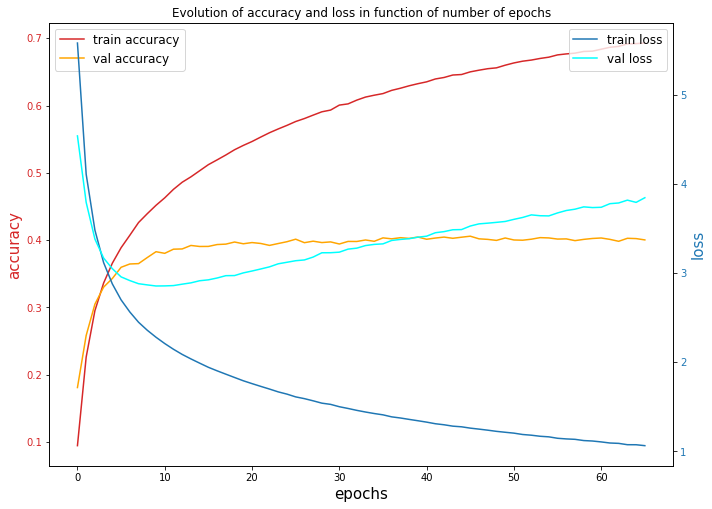

In [56]:
fig, ax1 = plt.subplots(figsize=(10,7))

color = 'tab:red'
ax1.set_xlabel('epochs', size = 15)
ax1.set_ylabel('accuracy', color=color, size = 15)
ax1.plot(epochs, acc, color=color, label = 'train accuracy')
ax1.plot(epochs, val_acc, color='orange', label = 'val accuracy')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('loss', color=color, size = 15)  # we already handled the x-label with ax1
ax2.plot(epochs, losses, color=color, label = 'train loss')
ax2.plot(epochs, val_losses, color='cyan', label = 'val loss')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Evolution of accuracy and loss in function of number of epochs")
ax1.legend(prop={'size': 12})
ax2.legend(prop={'size': 12})
plt.show()

As we could have imagined, the training loss keeps decreasing while the validation loss is at its minimum at epoch 10 and then increases (model overfits on loss). However, we are more interested in the accuracy of the model to predict the correct word. We see that the training accuracy keeps increasing while the validation accuracy becomes more less constant around epoch 20 but the accuracy does not overfit.

### Predict words from the test set

Once we have our trained model, we want to use it to compute predictions of words we could have in the testing set:

In [57]:
def load_all_data_for_genre(genre, tokenizer):
    """Helper function that loads all the useful data (neural net model, training history, 
    outnn_token_dict for samples trained on this genre...) for a given genre (path where the data are given)"""
    
    path_nn = 'NN_models/' + genre + '/' + genre + '_best_200k'
    
    # Load neural net model and history
    nn_model, training_hist = load_model(path_nn, True)
    print("Genre {} , max validation accuracy: {}".format(genre, max(training_hist['val_categorical_accuracy'])))
    
    # Load dictionary of {tokens -> output in neural net}
    token_outnn_dict = load_dict(path_nn + '/token_outnn_dict')
    outnn_token_dict = dict(zip(token_outnn_dict.values(), token_outnn_dict.keys()))
    
    # Load POS files for the wanted genre
    pos_counter, word_counter, word_pos_dict = get_files_from_genre(genre)
    
    # Recreate syllables dictionnary
    syllables_dic = pyphen.Pyphen(lang = 'en')
    # pyphen dic creates new string where syllables separated by '-'
    tok_syllab_dict = {tok:len(syllables_dic.inserted(tokenizer.index_word[tok]).split('-')) for tok in token_outnn_dict.keys()}
    
    return nn_model, training_hist, token_outnn_dict, outnn_token_dict, word_pos_dict, tok_syllab_dict

In [58]:
# Load tokenizer
with open('NN_models/tokenizer', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Load all the previously saved data useful for the wanted genre: neural net, sample words, POS of the words...
genre = 'pop'
pop_nn_model, pop_history, pop_token_outnn_dict, pop_outnn_token_dict, pop_word_pos_dict, pop_tok_syllab_dict = load_all_data_for_genre(genre, tokenizer)

# Load test files
path_nn = 'NN_models/' + genre + '/' + genre + '_best_200k'
test_file = path_nn + '/tests'
test = np.load(test_file + '.npz')
X_test, test_onehot_pos, test_onehot_syl, Y_test = test['array1'], test['array2'], test['array3'], test['array4']

Genre pop , max validation accuracy: 0.4058981233989692


In [59]:
def ngram_to_word(ngram, tok_word_dict):
    """
    Transform sequence of tokens to sequence of words
    """
    list_words = []
    for tok in ngram:
        if tok != 0:
            # tok == 0 -> padding at beginning
            list_words.append(tok_word_dict[tok])
    return list_words

# outnn_token_dict to map one-hot encoding prediction to the correct token
# tokenizer_index_word to map token to word
# pop_word_pos_dict to map token to part of speech

def get_predictions(nn_model, X_test, test_onehot_pos, test_onehot_syl, Y_test, batch_size, onehot_token_dict, tok_word_dict, word_pos_dict, tok_syl_dict):
    """Compute predictions of test set and display predictions compared to the real words"""
    
    predictions_onehot = nn_model.predict([X_test, test_onehot_pos, test_onehot_syl], batch_size = batch_size)
    pred_tokens = onehot_to_token(predictions_onehot, onehot_token_dict)
    
    pred_words = [tok_word_dict[tok] for tok in pred_tokens]
    real_words = [tok_word_dict[tok] for tok in Y_test]
    
    pred_pos = [word_pos_dict[w] for w in pred_words]
    real_pos = [word_pos_dict[w] for w in real_words]
    
    pred_syl = [tok_syl_dict[tok] for tok in pred_tokens]
    real_syl = [tok_syl_dict[tok] for tok in Y_test]
    
    acc_test = len([1 for i, word in enumerate(pred_words) if word == real_words[i]])/len(Y_test)
    acc_pos = len([1 for i, pos in enumerate(pred_pos) if pos == real_pos[i]])/len(Y_test)
    acc_syl = len([1 for i, syl in enumerate(pred_syl) if syl == real_syl[i]])/len(Y_test)
    
    print("Word Accuracy = {} ; POS Accuracy = {} ; Syllables Accuracy = {} \n".format(acc_test, acc_pos, acc_syl))
    
    for i, ngram in enumerate(X_test):
        seq_words = ngram_to_word(ngram, tok_word_dict)
        seq_words = ' '.join(seq_words)
        result = seq_words + ' ,' + real_words[i] + ' ----> ' + pred_words[i] + ' ( ' + real_pos[i] + ' , ' + pred_pos[i] + ' ) ; ( ' + str(real_syl[i]) + ' , ' + str(pred_syl[i]) + ' )'
        print(result)
    return pred_tokens

In [61]:
batch = 256
preds_tokens = get_predictions(pop_nn_model, X_test, test_onehot_pos, test_onehot_syl, Y_test, batch, pop_outnn_token_dict, tokenizer.index_word, pop_word_pos_dict, pop_tok_syllab_dict)


Word Accuracy = 0.40402144772117965 ; POS Accuracy = 0.998212689901698 ; Syllables Accuracy = 0.9996425379803396 

the past this is my ,second ----> private ( ADJ , ADJ ) ; ( 2 , 2 )
get messed up with you ,hello ----> alright ( INTJ , INTJ ) ; ( 2 , 2 )
whoa i whoa i ,whoa ----> yeah ( INTJ , INTJ ) ; ( 1 , 1 )
i kept you waiting for ,so ----> quite ( ADV , ADV ) ; ( 1 , 1 )
to undress it s all ,upside ----> truly ( ADV , ADV ) ; ( 2 , 2 )
own music sing your own ,special ----> grateful ( ADJ , ADJ ) ; ( 2 , 2 )
it down now voices carry ,hush ----> hush ( ADJ , ADJ ) ; ( 1 , 1 )
fills the air animals everywhere ,join ----> crank ( VERB , VERB ) ; ( 1 , 1 )
mash he did the monster ,mash ----> mash ( VERB , VERB ) ; ( 1 , 1 )
i ,may ----> woke ( VERB , VERB ) ; ( 1 , 1 )
slip away you re so ,rare ----> weird ( ADJ , ADJ ) ; ( 1 , 1 )
mountains rise standing there in ,front ----> front ( NOUN , NOUN ) ; ( 1 , 1 )
for you down down down ,karma ----> karma ( NOUN , NOUN ) ; ( 2 , 2 )
yulet

one day soon one day ,soon ----> again ( ADV , ADV ) ; ( 1 , 1 )
missed a warm embrace till ,april ----> april ( NOUN , NOUN ) ; ( 1 , 1 )
uhh uhhh if you creep ,pon ----> pon ( NOUN , NOUN ) ; ( 1 , 1 )
minute i get there the ,minute ----> way ( NOUN , NOUN ) ; ( 1 , 1 )
well i m nothing but ,trouble ----> anything ( NOUN , NOUN ) ; ( 2 , 2 )
trying to excite and mystify ,sharing ----> finding ( VERB , VERB ) ; ( 2 , 2 )
of hearing that line line ,line ----> line ( NOUN , NOUN ) ; ( 1 , 1 )
mine dynamite oh dynamite oh ,dynamite ----> dynamite ( NOUN , NOUN ) ; ( 3 , 3 )
she waits for her lover ,perhaps ----> somehow ( ADV , ADV ) ; ( 2 , 2 )
i m so dc like ,fat ----> most ( ADJ , ADJ ) ; ( 1 , 1 )
wide awake but still dreaming ,there ----> too ( ADV , ADV ) ; ( 1 , 1 )
blind would i ask a ,sane ----> sane ( ADJ , ADJ ) ; ( 1 , 1 )
taste my aiming watch me ,h ----> zoom ( NOUN , NOUN ) ; ( 1 , 1 )
bedtime prayer stickin little white ,flowers ----> feather ( NOUN , NOUN ) ; ( 2 , 2 )
o

now the way youve always ,understood ----> deliver ( VERB , VERB ) ; ( 3 , 3 )
meet her mama and papa ,louie ----> louie ( ADJ , ADJ ) ; ( 1 , 1 )
my job and my hair ,fell ----> grows ( VERB , VERB ) ; ( 1 , 1 )
be the one for me ,second ----> inner ( ADJ , ADJ ) ; ( 2 , 2 )
she s somehow closer now ,softly ----> softly ( ADV , ADV ) ; ( 2 , 2 )
i wish i wish you ,wished ----> wished ( VERB , VERB ) ; ( 1 , 1 )
wake up ,mr ----> off ( ADP , ADP ) ; ( 1 , 1 )
like an answer to a ,prayer ----> prayer ( NOUN , NOUN ) ; ( 1 , 1 )
i can t go on ,running ----> loving ( VERB , VERB ) ; ( 2 , 2 )
left me with he hangs ,up ----> round ( ADV , ADV ) ; ( 1 , 1 )
around you and so i ,beg ----> beg ( VERB , VERB ) ; ( 1 , 1 )
he held her hands she ,listened ----> whispered ( VERB , VERB ) ; ( 2 , 2 )
know to do it right ,kissin ----> gal ( NOUN , NOUN ) ; ( 1 , 1 )
me and nothing can come ,between ----> between ( ADP , ADP ) ; ( 2 , 2 )
feet i really love your ,tiger ----> tiger ( NOUN , NOUN ) ; (

me and i believe that ,faith ----> fact ( NOUN , NOUN ) ; ( 1 , 1 )
those years all those lies ,cling ----> stolen ( VERB , VERB ) ; ( 1 , 1 )
nana na nana na nana ,nana ----> nana ( NOUN , NOUN ) ; ( 1 , 1 )
t never had good love ,till ----> ga ( ADP , ADP ) ; ( 1 , 1 )
this bitch throwin up the ,seventeen ----> seventeen ( NUM , NUM ) ; ( 3 , 3 )
a tidal wave and sorrow ,swept ----> helps ( VERB , VERB ) ; ( 1 , 1 )
take a ride on my ,roller ----> roller ( NOUN , NOUN ) ; ( 1 , 1 )
so good it s just ,understood ----> remember ( VERB , VERB ) ; ( 3 , 3 )
you are marry me bracing ,facing ----> slipping ( VERB , VERB ) ; ( 2 , 2 )
t stand another chance he ,belongs ----> stumble ( VERB , VERB ) ; ( 2 , 2 )
you i would be running ,ohoh ----> ohoh ( NOUN , NOUN ) ; ( 1 , 1 )
thicker it becomes and the ,more ----> same ( ADJ , ADJ ) ; ( 1 , 1 )
i ever let you down ,cos ----> among ( ADP , ADP ) ; ( 1 , 1 )
again on me you can ,depend ----> depend ( VERB , VERB ) ; ( 2 , 2 )
twice never lea

can do when the fire ,burns ----> burns ( VERB , VERB ) ; ( 1 , 1 )
each other like professional wrestlers ,further ----> nigga ( ADV , ADV ) ; ( 2 , 2 )
oo oo maria oo oo ,oo ----> oo ( ADP , ADP ) ; ( 1 , 1 )
journey this day ends together ,far ----> ago ( ADV , ADV ) ; ( 1 , 1 )
ooh ,ooh ----> ooh ( INTJ , INTJ ) ; ( 1 , 1 )
there when you re feeling ,empty ----> empty ( ADJ , ADJ ) ; ( 2 , 2 )
while she s awake she ,takes ----> hears ( VERB , VERB ) ; ( 1 , 1 )
street ev rybody that i ,meet ----> loved ( VERB , VERB ) ; ( 1 , 1 )
my life sixteen clumsy and ,shy ----> weird ( ADJ , ADJ ) ; ( 1 , 1 )
poets for our dreams throwing ,feather ----> fantasies ( NOUN , NOUN ) ; ( 2 , 2 )
me and everything went all ,spinning ----> saying ( VERB , VERB ) ; ( 2 , 2 )
side cuddle up in a ,sleigh ----> dizzy ( ADJ , ADJ ) ; ( 1 , 1 )
keeps on burning and nobody ,knows ----> cares ( VERB , VERB ) ; ( 1 , 1 )
swim a single note he ,threw ----> pulls ( VERB , VERB ) ; ( 1 , 1 )
can not leave you a

ve been protective on a ,case ----> wheel ( NOUN , NOUN ) ; ( 1 , 1 )
the air with our blankets ,tight ----> aside ( ADV , ADV ) ; ( 1 , 1 )
be out there in the ,street ----> street ( NOUN , NOUN ) ; ( 1 , 1 )
to the days of christopher ,robin ----> robin ( NOUN , NOUN ) ; ( 1 , 1 )
s all about my feelings ,from ----> till ( ADP , ADP ) ; ( 1 , 1 )
all my rules got me ,tripping ----> tripping ( VERB , VERB ) ; ( 2 , 2 )
fucked your man boom i ,fucked ----> fucked ( VERB , VERB ) ; ( 1 , 1 )
my v i p colorful ,diamonds ----> diamonds ( NOUN , NOUN ) ; ( 3 , 3 )
wee crank that weezy wee ,crank ----> crank ( VERB , VERB ) ; ( 1 , 1 )
challenge you re doing to ,much ----> wrong ( ADJ , ADJ ) ; ( 1 , 1 )
in the morning when i ,wake ----> wake ( VERB , VERB ) ; ( 1 , 1 )
bleak side of the american ,experience ----> celebration ( NOUN , NOUN ) ; ( 4 , 4 )
your game i ve been ,watching ----> saving ( VERB , VERB ) ; ( 2 , 2 )
know i didn t wanna ,live ----> write ( VERB , VERB ) ; ( 1 , 1 )
tr

For the pop genre, the accuracy of predicting the exact same word from the testing set is 40 \% which is quite good because the neural network predicts one output over more than a thousand. The accuracy is the same as with the validation set in the neural network which is normal. The correct POS prediction is 99 \% as well as for the syllables accuracy. The results for the other genres is given below:

In [62]:
# Accuracies given from the test data
info_dict = {'pop':[0.4040, 0.9982, 0.9996], 'rock':[0.3174, 0.9819, 0.9996], 'metal':[0.2579, 0.9620, 0.9993], 'jazz':[0.4690, 0.9738, 0.9989], 'country':[0.3781, 0.9751, 0.9994], 'hiphop':[0.2512, 0.9216, 0.9997]}
info_df = pd.DataFrame.from_dict(info_dict)
info_df.rename(index = {0:'accuracy word', 1:'accuracy POS', 2:'accuracy syllables'})

,pop,rock,metal,jazz,country,hiphop
accuracy word,0.4040,0.3174,0.2579,0.4690,0.3781,0.2512
accuracy POS,0.9982,0.9819,0.9620,0.9738,0.9751,0.9216
accuracy syllables,0.9996,0.9996,0.9993,0.9989,0.9994,0.9997


### Lyrics Generation for a specific genre

We first need to predict what would be the next Parts Of Speech based on the one of the last word we have:

In [63]:
pos_counts = pickle.load(open("NN_models/pos_counts.p", "rb" ))
pos2idx = pickle.load(open("NN_models/pos2idx.p", "rb"))
pos_to_keep = {'INTJ','NOUN','ADV','PRON','VERB','ADP','DET','CCONJ','ADJ','NUM','PROPN'} 

def predict_next_pos(curr_pos):
    prob = pos_counts[pos2idx[curr_pos]]
    next_pos = ''
    while next_pos not in pos_to_keep:
        # Only predict a POS in the set that we trained on
        next_pos = np.random.choice(list(prob.keys()), p=list(prob.values()))
    return next_pos

predict_next_pos('NOUN')

'CCONJ'

In [64]:
# word_pos_dict = pop_word_pos_dict
# pos_index_dict
# syl_index_dict
# onehot_token_dict = outnn_token_dict
def generate_lyrics(nn_model, init_string, tokenizer, word_pos_dict, pos_index_dict, onehot_token_dict, words_to_generate = 20):
    """Function that generates lyrics by taking an initial string and predicts the next words by feeding input in the neural network"""
    # Convert string to list of tokens:
    init_list_words = init_string.split(' ')[-(n - 1):]
    init_list_tokens = [tokenizer.word_index[w] for w in init_list_words]
    
    # Get POS of last word:
    last_pos = [word_pos_dict[w] for w in init_list_words][-1]
    
    # Generate next tokens with the neural network
    tokens_list = init_list_tokens.copy()
    list_pos = []
    for i in range(words_to_generate):
        input_tokens = tokens_list[i:]
        
        pos_to_predict = predict_next_pos(last_pos)
        _, input_pos = token_to_onehot([pos_to_predict], pos_index_dict)
        # Syllables has no importance for generation of next words, if you want word with specific number of syllable, change next line
        input_syl = [0.0, 0.0, 0.0, 0.0]
        
        pred_onehot = nn_model.predict([[input_tokens], input_pos, [input_syl]])
        pred_token = onehot_to_token(pred_onehot, onehot_token_dict)
        real_pos = word_pos_dict[tokenizer.index_word[pred_token[0]]]
        
        tokens_list.append(pred_token[0])
        list_pos.append((pos_to_predict, real_pos))
        last_pos = real_pos
        
    
    # Convert tokens into a phrase
    list_words = ngram_to_word(tokens_list, tokenizer.index_word)
    sentence = ' '.join(list_words)
    print("Part of Speech (expected, predicted) ---> {} \n".format(list_pos))
    return sentence

In [65]:
initial = 'i m in love with'
generated_lyrs = generate_lyrics(pop_nn_model, initial, tokenizer, pop_word_pos_dict, pos_index_dict, pop_outnn_token_dict, words_to_generate = 40)
print(generated_lyrs)

Part of Speech (expected, predicted) ---> [('DET', 'DET'), ('NOUN', 'NOUN'), ('ADP', 'ADP'), ('PRON', 'PRON'), ('VERB', 'VERB'), ('PRON', 'PRON'), ('VERB', 'VERB'), ('ADP', 'ADP'), ('PRON', 'PRON'), ('ADP', 'ADP'), ('DET', 'DET'), ('NOUN', 'NOUN'), ('PRON', 'PRON'), ('VERB', 'VERB'), ('PRON', 'PRON'), ('VERB', 'VERB'), ('PRON', 'ADJ'), ('VERB', 'ADJ'), ('NOUN', 'NOUN'), ('VERB', 'VERB'), ('PRON', 'ADJ'), ('NOUN', 'NOUN'), ('ADP', 'ADP'), ('PRON', 'PRON'), ('VERB', 'VERB'), ('DET', 'DET'), ('NOUN', 'NOUN'), ('ADP', 'ADP'), ('DET', 'DET'), ('NOUN', 'NOUN'), ('ADP', 'ADP'), ('PRON', 'PRON'), ('PRON', 'PRON'), ('ADP', 'ADP'), ('DET', 'DET'), ('NOUN', 'NOUN'), ('CCONJ', 'CCONJ'), ('VERB', 'VERB'), ('DET', 'DET'), ('ADJ', 'ADJ')] 

i m in love with every minute underneath yah satisfy it satisfy underneath yah underneath another cloud we appreciate ourselves worship everlasting everlasting joy worship everlasting inspiration underneath itself traveling another mountain underneath another tree

We can see that this lyrics generations sometimes has not much sense and it can predict the same word again and again. The generation could have been better by predicting the next POS not only on the POS of the last word but on the POS of the 2 or 3 last words.

#### Convert lyrics from one genre to another one:

Let's check the lyrics we can get from one genre: pop for instance to the other genres

In [66]:
# Pick a pop song that has some interesting words that we could change
pop_song = list_lyrs_pop[5600]
print(' '.join(pop_song) + '\n')

pos_index_dict = load_dict('NN_models/POS_index_dict')
syl_index_dict = load_dict('NN_models/syllables_index_dict')
n = 6 # for ngrams: size of tokens input of neural network, typically 6

syllables_dic = pyphen.Pyphen(lang = 'en')
# pyphen dic creates new string where syllables separated by '-'
tok_syllab_dict = {tok:len(syllables_dic.inserted(tokenizer.index_word[tok]).split('-')) for tok in token_outnn_dict.keys()}

check it out it s eleventhirty my hand is getting dirty snatchin up things that probably can t be worth it now this is a vision of a violent life livin by a gun and totem of the night i m slammin doors 245 n pullin the keys now these are the valuable luxuries to me at the early dawn before you yawn i ve been there swiped you and then i m gone now it s my heart tictacs a black satin bag full of bad ass rocks my identity has to be exposed stealing from the spot that i truly chosed i lose and my choice to chose now i m fix and i m fallin deeper in the mix there s no hope for me see my path has been chosen i m johnny be chorus johnny behow much there is to see just open your eyes and listen to me straight ahead a green light turns to red ooh why can t you see ooh johnny be chorus the situation s tight you are billin by the night can t choose between the wrongs and the rights i m searchin for the clues yowhat am i gotta do i got the habit to take valuable things from you here i stand and i 

In [67]:
# Get the words that we would like to change and get the inputs to feed the neural network
def get_words_to_change(lyrics, genre_typical_words, genre_word_pos_dict, amount = 10):
    """
    Function that gets the most common words in the lyrics given a sorted list for a specific genre
    lyrics: list of strings (the lyrics of a song)
    genre_typical_words: the sorted list of typical words of a genre (pop_diff_list for pop), format: tuples (word, diff_count)
    amount: the number of words we want to change in the lyrics
    """
    words_to_change = []
    words_to_change_pos = []
    found_words = 0 
    for w, _ in genre_typical_words:
        if w in lyrics:
            words_to_change.append(w)
            words_to_change_pos.append([(word, i) for i, word in enumerate(lyrics) if word == w])
            found_words += 1
        if found_words == amount:
            break
    print("List of words to change in the lyrics: {}".format(words_to_change))
    words_to_change_pos = [w for l in words_to_change_pos for w in l]
    words_to_change_pos = sorted(words_to_change_pos, key = lambda x: x[1])
    
    tokens_to_change = [tokenizer.word_index[w] for w in words_to_change]
    lyrics_tokens = (n - 1) * [0] + [tokenizer.word_index[w] for w in lyrics] # Append 0 tokens at beginning in case of 
    
    # Get the tokens ngrams for sentences before the tokens to change (input of the neural net)
    ngrams_with_output = np.array(ngram_lyrics(n, lyrics_tokens, samples_tokens = tokens_to_change))
    input_ngrams = ngrams_with_output[:,:-1]
    output = ngrams_with_output[:,-1]
    
    # Get the POS of tokens that we want to predict
    tok_pos_dict = {tokenizer.word_index[w] : genre_word_pos_dict[w] for w in words_to_change}
    _, input_onehot_pos = token_to_onehot(output, pos_index_dict, tok_pos_dict)
    
    # Get the #syllables of tokens that we want to predict
    tok_syllab_dict = {tokenizer.word_index[w]:len(syllables_dic.inserted(w).split('-')) for w in words_to_change}
    _, input_onehot_syl = token_to_onehot(output, syl_index_dict, tok_syllab_dict)
    
    nn_input = [input_ngrams, input_onehot_pos, input_onehot_syl]
    return nn_input, output

pop_nn_input, pop_output = get_words_to_change(pop_song, pop_diff_list, pop_word_pos_dict, amount = 25)

List of words to change in the lyrics: ['sleepless', 'frightened', 'stealing', 'searchin', 'habit', 'rights', 'spirits', 'drifting', 'chose', 'chosen', 'truly', 'situation', 'johnny', 'certain', 'mix', 'fallin', 'keys', 'deeper', 'callin', 'fix', 'calls', 'repeat', 'trapped', 'breeze', 'doors']


In [68]:
from IPython.display import Markdown, display

def predict_new_words(g2_nn_model, g1_nn_input, outputs_tokens, g2_outnn_token_dict):
    """
    Given neural network of other genre (g2) and input of genre 1 (g1) from the song, compute the prediction from g1 to g2 
    """
    predictions_onehot = g2_nn_model.predict(g1_nn_input)
    pred_tokens = onehot_to_token(predictions_onehot, g2_outnn_token_dict)
    
    pred_words = [tokenizer.index_word[tok] for tok in pred_tokens]
    real_words = [tokenizer.index_word[tok] for tok in outputs_tokens]
    
    return list(zip(real_words, pred_words))

def printmd(string):
    display(Markdown(string))

def get_new_lyrics(lyrics, real_pred_list):
    """
    Function that gives the new lyrics based on predictions generated from the other genre
    real_pred_list: sorted list of apparition of tuples: (real word, predicted word)
    """
    # real_pred_list sorted in order of apparition
    new_lyrics = []
    idx = 0
    for w in lyrics:
        if idx < len(real_pred_list):
            real_w, pred_w = real_pred_list[idx]
        if w == real_w:
            new_lyrics.append('**' + pred_w + '**')
            idx += 1
        else:
            new_lyrics.append(w)
    print("Converted lyrics:")
    printmd(' '.join(new_lyrics) + '\n')
    return new_lyrics
    

Predict to metal genre:

In [69]:
genre = 'metal'
metal_nn_model, _, _, metal_outnn_token_dict, _, _ = load_all_data_for_genre(genre, tokenizer)

Genre metal , max validation accuracy: 0.26767676764392767


In [70]:
metal_preds_list = predict_new_words(metal_nn_model, pop_nn_input, pop_output, metal_outnn_token_dict)
metal_pop_lyrs = get_new_lyrics(pop_song, metal_preds_list)

print(metal_preds_list)

Converted lyrics:


check it out it s eleventhirty my hand is getting dirty snatchin up things that probably can t be worth it now this is a vision of a violent life livin by a gun and totem of the night i m slammin **wit** 245 n pullin the **road** now these are the valuable luxuries to me at the early dawn before you yawn i ve been there swiped you and then i m gone now it s my heart tictacs a black satin bag full of bad ass rocks my identity has to be exposed **revealed** from the spot that i **nigga** chosed i lose and my choice to **sell** now i m **telling** and i m **comin** **little** in the **abyss** there s no hope for me see my path has been **unleashed** i m **centuries** be chorus **chorus** behow much there is to see just open your eyes and listen to me straight ahead a green light turns to red ooh why can t you see ooh **chorus** be chorus the **infinity** s tight you are billin by the night can t choose between the wrongs and the **anger** i m **free** for the clues yowhat am i gotta do i got the **rules** to take valuable things from you here i stand and i m physically **can** by my tent **staring** northern **oceans** is this adman a lonely path when i stand alone a round by my own here i lay down into **hopeless** dephts two **warriors** **rip** grabs my very last breath sometimes i wish in my path a simple gesture or a simple laugh but i m evil dirty and mean two pounds blood pass through my bloodstream **unseen** huh you should be who am i i m **nothing** be chorus here we go here we go now check the flow here we go **nothing** beis in control **attack** it s a **problem** night he s **dragon** your name it s a lonely ride i know how you saw him again and again he s dressin his dreams yeah **murder** my friend it s not what it seems **niggas** chorus twice


[('doors', 'wit'), ('keys', 'road'), ('stealing', 'revealed'), ('truly', 'nigga'), ('chose', 'sell'), ('fix', 'telling'), ('fallin', 'comin'), ('deeper', 'little'), ('mix', 'abyss'), ('chosen', 'unleashed'), ('johnny', 'centuries'), ('johnny', 'chorus'), ('johnny', 'chorus'), ('situation', 'infinity'), ('rights', 'anger'), ('searchin', 'free'), ('habit', 'rules'), ('trapped', 'can'), ('drifting', 'staring'), ('breeze', 'oceans'), ('certain', 'hopeless'), ('spirits', 'warriors'), ('calls', 'rip'), ('frightened', 'unseen'), ('johnny', 'nothing'), ('johnny', 'nothing'), ('repeat', 'attack'), ('sleepless', 'problem'), ('callin', 'dragon'), ('johnny', 'murder'), ('repeat', 'niggas')]


Predict to rock genre:

In [71]:
genre = 'rock'
rock_nn_model, _, _, rock_outnn_token_dict, _, _ = load_all_data_for_genre(genre, tokenizer)

Genre rock , max validation accuracy: 0.3194070080541215


In [72]:
rock_preds_list = predict_new_words(rock_nn_model, pop_nn_input, pop_output, rock_outnn_token_dict)
rock_pop_lyrs = get_new_lyrics(pop_song, rock_preds_list)

print(rock_preds_list)

Converted lyrics:


check it out it s eleventhirty my hand is getting dirty snatchin up things that probably can t be worth it now this is a vision of a violent life livin by a gun and totem of the night i m slammin **tin** 245 n pullin the **pony** now these are the valuable luxuries to me at the early dawn before you yawn i ve been there swiped you and then i m gone now it s my heart tictacs a black satin bag full of bad ass rocks my identity has to be exposed **covered** from the spot that i **simply** chosed i lose and my choice to **speak** now i m **strung** and i m **talkin** **jenny** in the **tides** there s no hope for me see my path has been **taken** i m **nothing** be chorus **brother** behow much there is to see just open your eyes and listen to me straight ahead a green light turns to red ooh why can t you see ooh **motel** be chorus the **revolution** s tight you are billin by the night can t choose between the wrongs and the **knives** i m **amazed** for the clues yowhat am i gotta do i got the **key** to take valuable things from you here i stand and i m physically **screwed** by my tent **writing** northern **heat** is this adman a lonely path when i stand alone a round by my own here i lay down into **deepest** dephts two **buildings** **ran** grabs my very last breath sometimes i wish in my path a simple gesture or a simple laugh but i m evil dirty and mean two pounds blood pass through my bloodstream **satan** huh you should be who am i i m **outta** be chorus here we go here we go now check the flow here we go **something** beis in control **vision** it s a **breakdown** night he s **gettin** your name it s a lonely ride i know how you saw him again and again he s dressin his dreams yeah **dreamers** my friend it s not what it seems **doctor** chorus twice


[('doors', 'tin'), ('keys', 'pony'), ('stealing', 'covered'), ('truly', 'simply'), ('chose', 'speak'), ('fix', 'strung'), ('fallin', 'talkin'), ('deeper', 'jenny'), ('mix', 'tides'), ('chosen', 'taken'), ('johnny', 'nothing'), ('johnny', 'brother'), ('johnny', 'motel'), ('situation', 'revolution'), ('rights', 'knives'), ('searchin', 'amazed'), ('habit', 'key'), ('trapped', 'screwed'), ('drifting', 'writing'), ('breeze', 'heat'), ('certain', 'deepest'), ('spirits', 'buildings'), ('calls', 'ran'), ('frightened', 'satan'), ('johnny', 'outta'), ('johnny', 'something'), ('repeat', 'vision'), ('sleepless', 'breakdown'), ('callin', 'gettin'), ('johnny', 'dreamers'), ('repeat', 'doctor')]


Predict to jazz genre:

In [73]:
genre = 'jazz'
jazz_nn_model, _, _, jazz_outnn_token_dict, _, _ = load_all_data_for_genre(genre, tokenizer)

Genre jazz , max validation accuracy: 0.4808471452684912


In [74]:
jazz_preds_list = predict_new_words(jazz_nn_model, pop_nn_input, pop_output, jazz_outnn_token_dict)
jazz_pop_lyrs = get_new_lyrics(pop_song, jazz_preds_list)

print(jazz_preds_list)

Converted lyrics:


check it out it s eleventhirty my hand is getting dirty snatchin up things that probably can t be worth it now this is a vision of a violent life livin by a gun and totem of the night i m slammin **jack** 245 n pullin the **bass** now these are the valuable luxuries to me at the early dawn before you yawn i ve been there swiped you and then i m gone now it s my heart tictacs a black satin bag full of bad ass rocks my identity has to be exposed **destroy** from the spot that i **never** chosed i lose and my choice to **fight** now i m **tied** and i m **shakin** **deeper** in the **wind** there s no hope for me see my path has been **covered** i m **longing** be chorus **johnny** behow much there is to see just open your eyes and listen to me straight ahead a green light turns to red ooh why can t you see ooh **doggone** be chorus the **mississippi** s tight you are billin by the night can t choose between the wrongs and the **years** i m **guilty** for the clues yowhat am i gotta do i got the **st** to take valuable things from you here i stand and i m physically **raised** by my tent **lying** northern **stream** is this adman a lonely path when i stand alone a round by my own here i lay down into **second** dephts two **women** **bound** grabs my very last breath sometimes i wish in my path a simple gesture or a simple laugh but i m evil dirty and mean two pounds blood pass through my bloodstream **welcome** huh you should be who am i i m **longing** be chorus here we go here we go now check the flow here we go **mountains** beis in control **flower** it s a **mystery** night he s **waitin** your name it s a lonely ride i know how you saw him again and again he s dressin his dreams yeah **shadow** my friend it s not what it seems **mystery** chorus twice


[('doors', 'jack'), ('keys', 'bass'), ('stealing', 'destroy'), ('truly', 'never'), ('chose', 'fight'), ('fix', 'tied'), ('fallin', 'shakin'), ('deeper', 'deeper'), ('mix', 'wind'), ('chosen', 'covered'), ('johnny', 'longing'), ('johnny', 'johnny'), ('johnny', 'doggone'), ('situation', 'mississippi'), ('rights', 'years'), ('searchin', 'guilty'), ('habit', 'st'), ('trapped', 'raised'), ('drifting', 'lying'), ('breeze', 'stream'), ('certain', 'second'), ('spirits', 'women'), ('calls', 'bound'), ('frightened', 'welcome'), ('johnny', 'longing'), ('johnny', 'mountains'), ('repeat', 'flower'), ('sleepless', 'mystery'), ('callin', 'waitin'), ('johnny', 'shadow'), ('repeat', 'mystery')]


Predict to country genre:

In [75]:
genre = 'country'
country_nn_model, _, _, country_outnn_token_dict, _, _ = load_all_data_for_genre(genre, tokenizer)

Genre country , max validation accuracy: 0.3879162702358529


In [76]:
country_preds_list = predict_new_words(country_nn_model, pop_nn_input, pop_output, country_outnn_token_dict)
country_pop_lyrs = get_new_lyrics(pop_song, country_preds_list)

print(country_preds_list)

Converted lyrics:


check it out it s eleventhirty my hand is getting dirty snatchin up things that probably can t be worth it now this is a vision of a violent life livin by a gun and totem of the night i m slammin **porch** 245 n pullin the **boots** now these are the valuable luxuries to me at the early dawn before you yawn i ve been there swiped you and then i m gone now it s my heart tictacs a black satin bag full of bad ass rocks my identity has to be exposed **cover** from the spot that i **already** chosed i lose and my choice to **cut** now i m **knowin** and i m **losin** **deeper** in the **rain** there s no hope for me see my path has been **begun** i m **travelin** be chorus **johnny** behow much there is to see just open your eyes and listen to me straight ahead a green light turns to red ooh why can t you see ooh **sweetheart** be chorus the **mississippi** s tight you are billin by the night can t choose between the wrongs and the **roads** i m **afraid** for the clues yowhat am i gotta do i got the **news** to take valuable things from you here i stand and i m physically **crossed** by my tent **staring** northern **cloud** is this adman a lonely path when i stand alone a round by my own here i lay down into **dixie** dephts two **stories** **shall** grabs my very last breath sometimes i wish in my path a simple gesture or a simple laugh but i m evil dirty and mean two pounds blood pass through my bloodstream **deeper** huh you should be who am i i m **drivin** be chorus here we go here we go now check the flow here we go **preacher** beis in control **yonder** it s a **jukebox** night he s **drivin** your name it s a lonely ride i know how you saw him again and again he s dressin his dreams yeah **horses** my friend it s not what it seems **laughter** chorus twice


[('doors', 'porch'), ('keys', 'boots'), ('stealing', 'cover'), ('truly', 'already'), ('chose', 'cut'), ('fix', 'knowin'), ('fallin', 'losin'), ('deeper', 'deeper'), ('mix', 'rain'), ('chosen', 'begun'), ('johnny', 'travelin'), ('johnny', 'johnny'), ('johnny', 'sweetheart'), ('situation', 'mississippi'), ('rights', 'roads'), ('searchin', 'afraid'), ('habit', 'news'), ('trapped', 'crossed'), ('drifting', 'staring'), ('breeze', 'cloud'), ('certain', 'dixie'), ('spirits', 'stories'), ('calls', 'shall'), ('frightened', 'deeper'), ('johnny', 'drivin'), ('johnny', 'preacher'), ('repeat', 'yonder'), ('sleepless', 'jukebox'), ('callin', 'drivin'), ('johnny', 'horses'), ('repeat', 'laughter')]


Predict to hip hop genre:

In [77]:
genre = 'hiphop'
hip_nn_model, _, _, hip_outnn_token_dict, _, _ = load_all_data_for_genre(genre, tokenizer)

Genre hiphop , max validation accuracy: 0.2541998231284498


In [78]:
hip_preds_list = predict_new_words(hip_nn_model, pop_nn_input, pop_output, hip_outnn_token_dict)
hip_pop_lyrs = get_new_lyrics(pop_song, hip_preds_list)

print(hip_preds_list)

Converted lyrics:


check it out it s eleventhirty my hand is getting dirty snatchin up things that probably can t be worth it now this is a vision of a violent life livin by a gun and totem of the night i m slammin **cats** 245 n pullin the **keys** now these are the valuable luxuries to me at the early dawn before you yawn i ve been there swiped you and then i m gone now it s my heart tictacs a black satin bag full of bad ass rocks my identity has to be exposed **approach** from the spot that i **hardly** chosed i lose and my choice to **float** now i m **bringin** and i m **bustin** **lower** in the **joint** there s no hope for me see my path has been **written** i m **thuggin** be chorus **busta** behow much there is to see just open your eyes and listen to me straight ahead a green light turns to red ooh why can t you see ooh **sippin** be chorus the **motherfucker** s tight you are billin by the night can t choose between the wrongs and the **homies** i m **catchin** for the clues yowhat am i gotta do i got the **cheese** to take valuable things from you here i stand and i m physically **trapped** by my tent **faded** northern **gats** is this adman a lonely path when i stand alone a round by my own here i lay down into **concrete** dephts two **killas** **split** grabs my very last breath sometimes i wish in my path a simple gesture or a simple laugh but i m evil dirty and mean two pounds blood pass through my bloodstream **ninja** huh you should be who am i i m **tryna** be chorus here we go here we go now check the flow here we go **brooklyn** beis in control **somebody** it s a **planet** night he s **gettin** your name it s a lonely ride i know how you saw him again and again he s dressin his dreams yeah **thuggin** my friend it s not what it seems **somethin** chorus twice


[('doors', 'cats'), ('keys', 'keys'), ('stealing', 'approach'), ('truly', 'hardly'), ('chose', 'float'), ('fix', 'bringin'), ('fallin', 'bustin'), ('deeper', 'lower'), ('mix', 'joint'), ('chosen', 'written'), ('johnny', 'thuggin'), ('johnny', 'busta'), ('johnny', 'sippin'), ('situation', 'motherfucker'), ('rights', 'homies'), ('searchin', 'catchin'), ('habit', 'cheese'), ('trapped', 'trapped'), ('drifting', 'faded'), ('breeze', 'gats'), ('certain', 'concrete'), ('spirits', 'killas'), ('calls', 'split'), ('frightened', 'ninja'), ('johnny', 'tryna'), ('johnny', 'brooklyn'), ('repeat', 'somebody'), ('sleepless', 'planet'), ('callin', 'gettin'), ('johnny', 'thuggin'), ('repeat', 'somethin')]
